In [32]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
os.chdir("C:/Users/benlc/OneDrive/Desktop/python_learn/song-prediction")

In [5]:
# check overview
train = pd.read_csv(os.getcwd() + "/data/train.csv")
train.head()

id  song_duration_ms  acousticness  danceability    energy  \
0   0          212990.0      0.642286      0.856520  0.707073   
1   1               NaN      0.054866      0.733289  0.835545   
2   2          193213.0           NaN      0.188387  0.783524   
3   3          249893.0      0.488660      0.585234  0.552685   
4   4          165969.0      0.493017           NaN  0.740982   

   instrumentalness   key  liveness  loudness  audio_mode  speechiness  \
0          0.002001  10.0       NaN -5.619088           0     0.082570   
1          0.000996   8.0  0.436428 -5.236965           1     0.127358   
2         -0.002694   5.0  0.170499 -4.951759           0     0.052282   
3          0.000608   0.0  0.094805 -7.893694           0     0.035618   
4          0.002033  10.0  0.094891 -2.684095           0     0.050746   

        tempo  time_signature  audio_valence  song_popularity  
0  158.386236               4       0.734642                0  
1  102.752988               3       0.711531                1  
2  178.685791               3       0.425536                0  
3  128.715630               3       0.453597                0  
4  121.928157               4       0.741311                0

## Check data summary and missingness

In [6]:
# check overview
train.describe()

id  song_duration_ms  acousticness  danceability  \
count  40000.00000      35899.000000  36008.000000  35974.000000   
mean   19999.50000     193165.847572      0.276404      0.570951   
std    11547.14972      45822.127679      0.297928      0.190010   
min        0.00000      25658.000000     -0.013551      0.043961   
25%     9999.75000     166254.500000      0.039618      0.424760   
50%    19999.50000     186660.000000      0.140532      0.608234   
75%    29999.25000     215116.000000      0.482499      0.718464   
max    39999.00000     491671.000000      1.065284      0.957131   

             energy  instrumentalness           key      liveness  \
count  36025.000000      36015.000000  35935.000000  35914.000000   
mean       0.683932          0.036527      5.042605      0.198514   
std        0.212662          0.150024      3.372728      0.151670   
min       -0.001682         -0.004398      0.000000      0.027843   
25%        0.539276          0.000941      2.000000      0.111796   
50%        0.704453          0.001974      5.000000      0.135945   
75%        0.870503          0.003225      8.000000      0.212842   
max        1.039741          1.075415     11.000000      1.065298   

           loudness    audio_mode   speechiness         tempo  time_signature  \
count  36043.000000  40000.000000  40000.000000  40000.000000    40000.000000   
mean      -7.407596      0.321150      0.094107    116.562815        3.394375   
std        3.877198      0.466924      0.083591     26.167911        0.524405   
min      -32.117911      0.000000      0.015065     62.055779        2.000000   
25%       -9.578139      0.000000      0.038500     96.995309        3.000000   
50%       -6.345413      0.000000      0.055881    113.795959        3.000000   
75%       -4.620711      1.000000      0.118842    128.517383        4.000000   
max       -0.877346      1.000000      0.560748    219.163578        5.000000   

       audio_valence  song_popularity  
count   40000.000000     40000.000000  
mean        0.580645         0.364400  
std         0.237351         0.481268  
min         0.013398         0.000000  
25%         0.398669         0.000000  
50%         0.598827         0.000000  
75%         0.759635         1.000000  
max         1.022558         1.000000

In [7]:
# convert column to categorical
cat_vars = ['key','audio_mode','time_signature','song_popularity']
train[cat_vars] = train[cat_vars].astype("category")
train.dtypes

id                     int64
song_duration_ms     float64
acousticness         float64
danceability         float64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
audio_mode          category
speechiness          float64
tempo                float64
time_signature      category
audio_valence        float64
song_popularity     category
dtype: object

In [8]:
train['key'].isnull().mean()

0.101625

In [9]:
# Find variables with missing observations
vars_with_na = [var for var in train.columns if train[var].isnull().mean() > 0]
vars_with_na

['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness']

In [10]:
# Calculate percentage of missingness
data_na = pd.DataFrame(train[vars_with_na].isnull().mean().reset_index())
data_na.columns = ['variable','na_percentage']

data_na.sort_values(by = 'na_percentage', ascending=False, inplace=True)
data_na

variable  na_percentage
0  song_duration_ms       0.102525
6          liveness       0.102150
5               key       0.101625
2      danceability       0.100650
1      acousticness       0.099800
4  instrumentalness       0.099625
3            energy       0.099375
7          loudness       0.098925

# Check if it is missing at random

In [12]:
def missing_analysis(df, selected_col):
    '''
    check if other columns distribution change if selected column with NA observations compared with non-NA observation
    1) continuous variable will use kdeplot
    2) category variable will use barplot
    '''

    # create column with missing and non-missing indicator
    full_df = df.copy()
    full_df['x_missing']  = np.where(full_df[selected_col].isnull(), "missing", "not_missing")
    full_df['x_missing'] = full_df['x_missing'].astype("category").cat.as_ordered()
    full_df


    # print continuous distribution
    for i, feature in enumerate(cont_vars):
        plt.figure()  # forces a new figure
        sns.kdeplot(data=full_df[full_df['x_missing'] == "not_missing"], x=feature).set_title("not_missing")
        plt.figure()  # forces a new figure
        sns.kdeplot(data=full_df[full_df['x_missing'] == "missing"], x=feature).set_title("missing")
        print("{} plotting {} ".format(i,feature))

    # print category percentage plot
    for i, feature in enumerate(cat_vars):
        full_df[feature] = full_df[feature].cat.as_ordered()
        plt.figure()
        sns.histplot(full_df[full_df['x_missing'] == "not_missing"], x=feature, stat="probability", multiple="dodge", shrink=.8).set_title("not_missing")
        plt.figure()
        sns.histplot(full_df[full_df['x_missing'] == "missing"], x=feature, stat="probability", multiple="dodge", shrink=.8).set_title("missing")
        print("{} plotting {} ".format(i,feature))

0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 


<ipython-input-12-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


0 plotting key 
1 plotting audio_mode 
2 plotting time_signature 
3 plotting song_popularity 


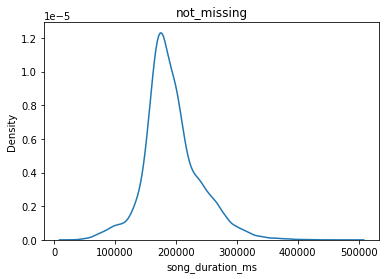

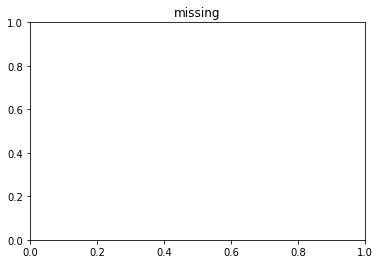

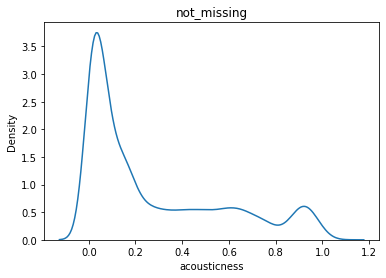

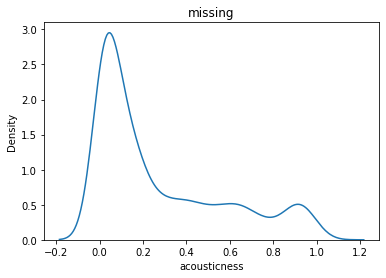

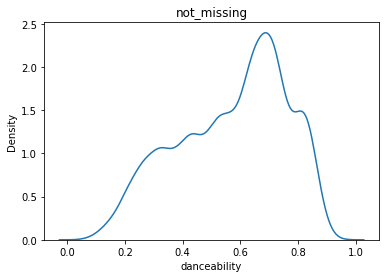

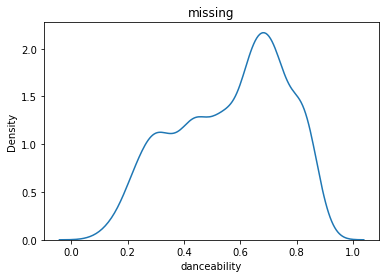

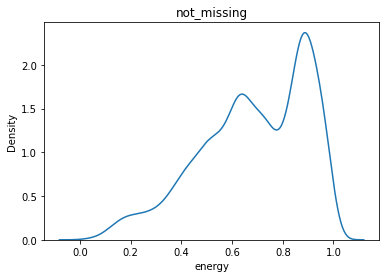

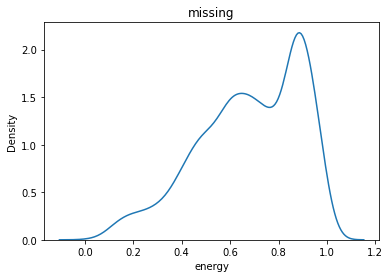

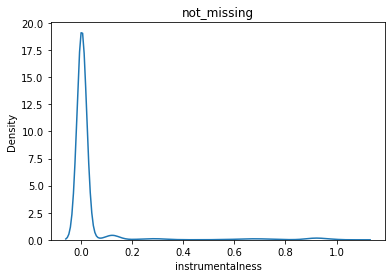

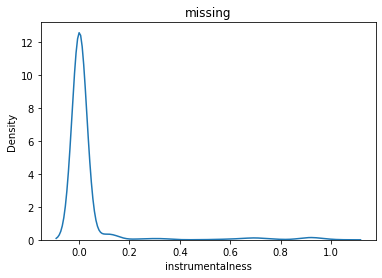

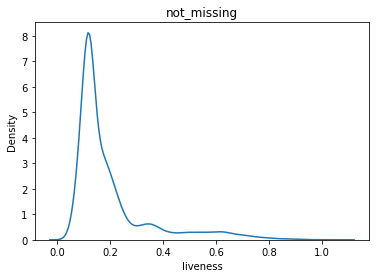

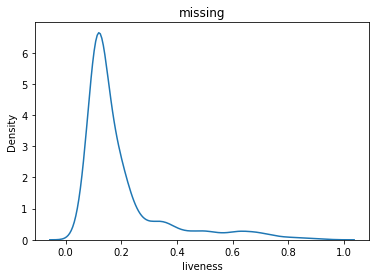

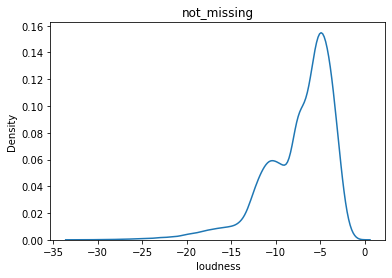

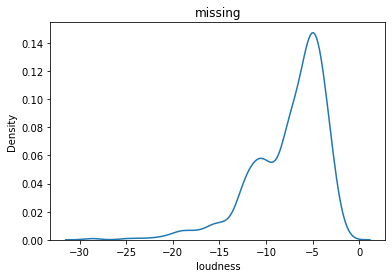

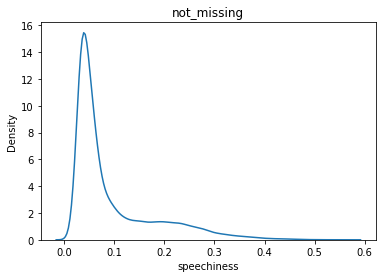

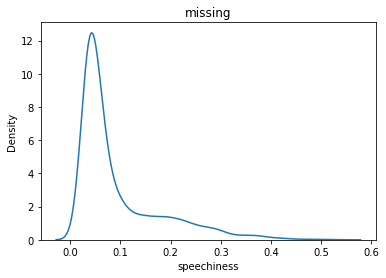

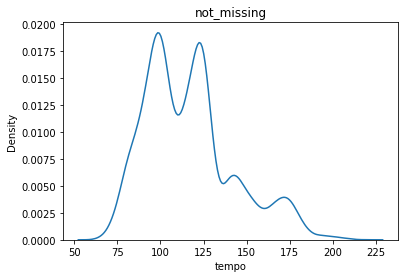

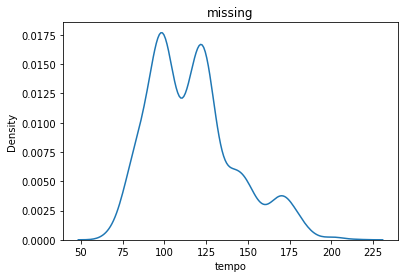

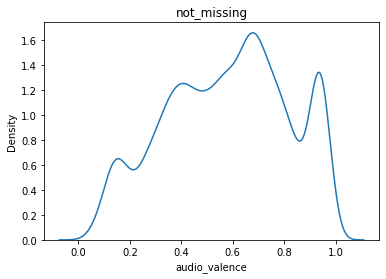

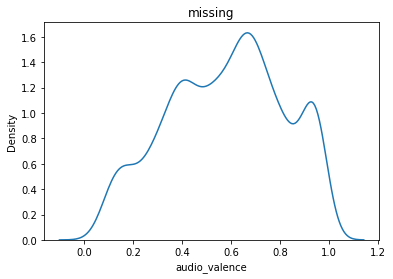

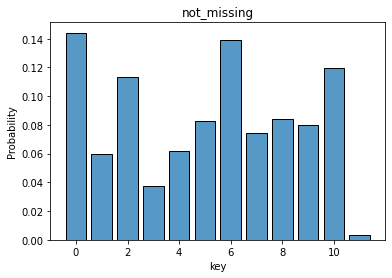

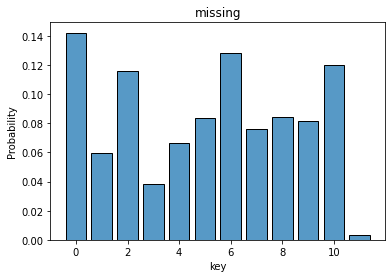

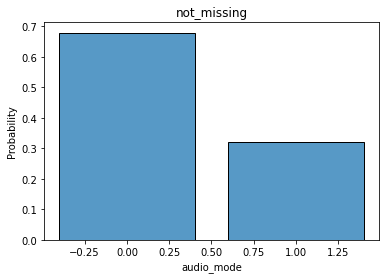

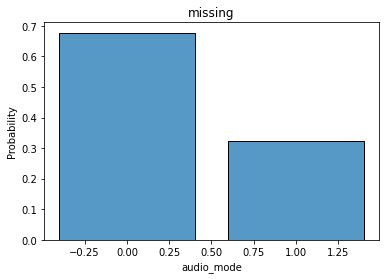

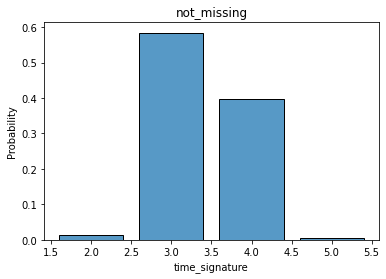

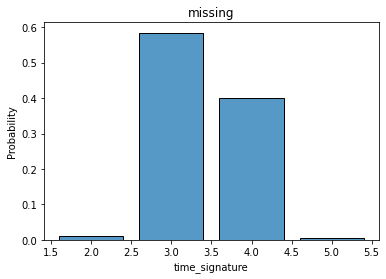

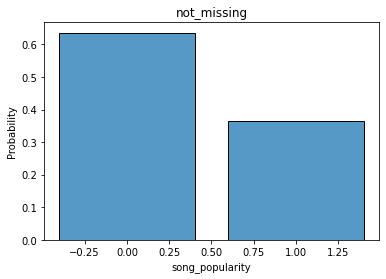

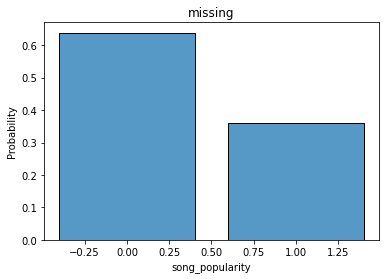

In [13]:
# check distribution / bar chart after and before remove na
cont_vars = [var for var in train.columns if var not in cat_vars]
cont_vars.remove('id')

# check song_duration_ms column
# no difference found
missing_analysis(df = train, selected_col= 'song_duration_ms')


0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 
0 plotting key 
1 plotting audio_mode 


<ipython-input-101-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2 plotting time_signature 
3 plotting song_popularity 


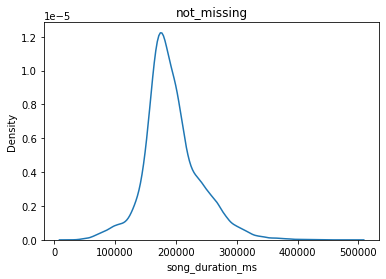

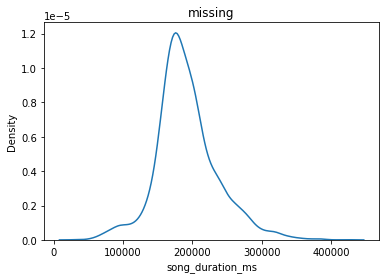

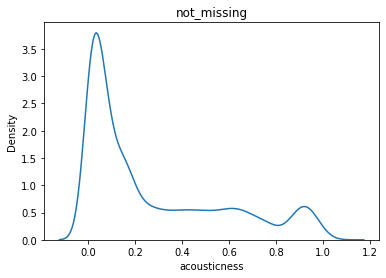

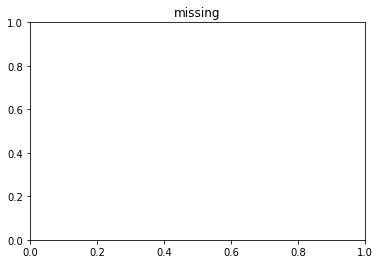

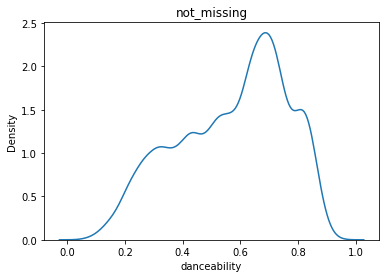

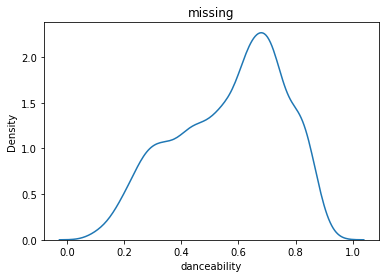

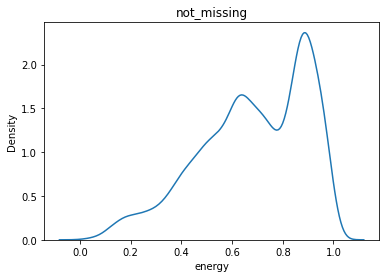

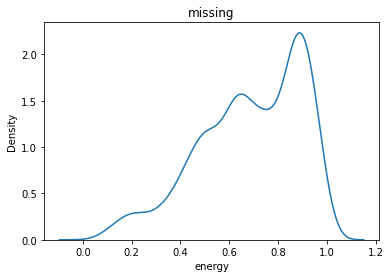

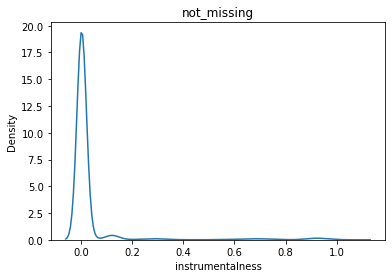

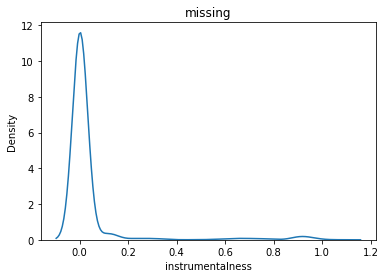

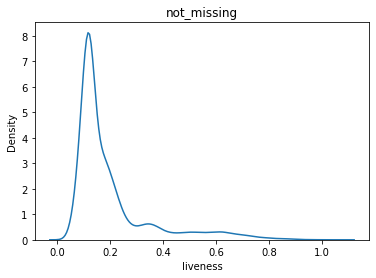

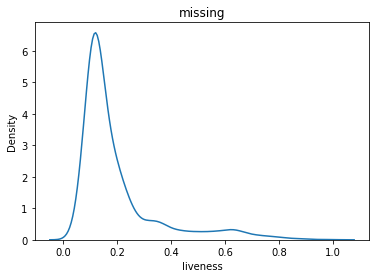

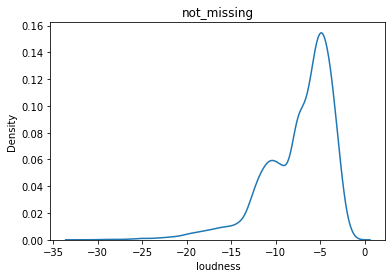

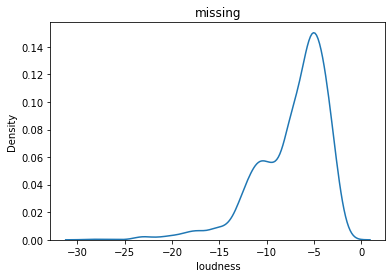

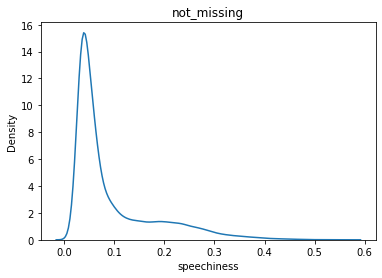

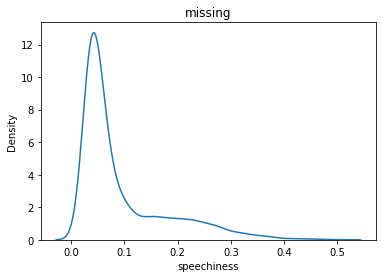

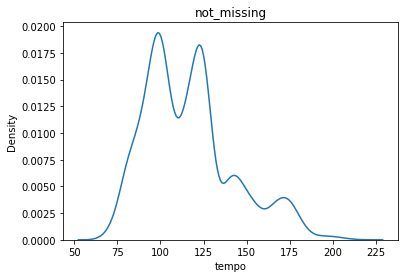

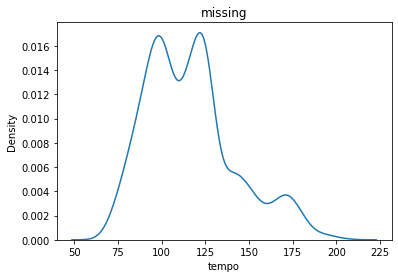

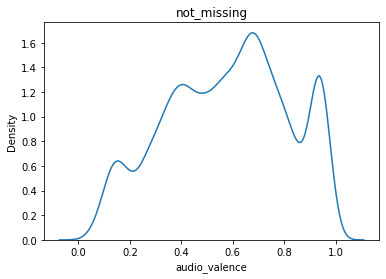

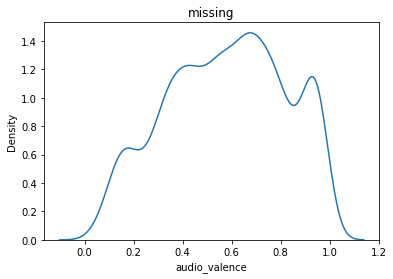

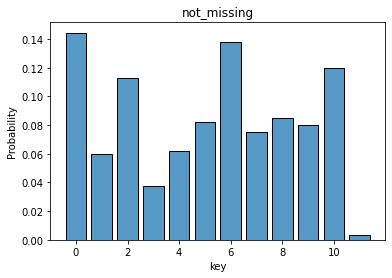

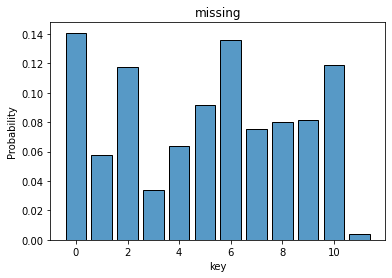

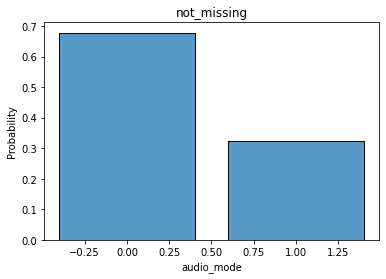

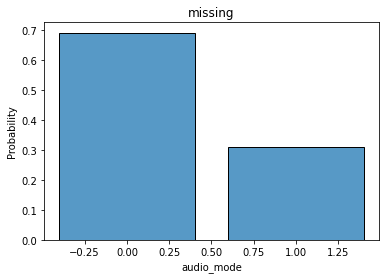

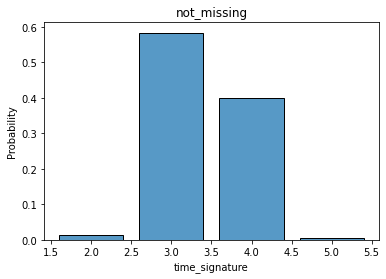

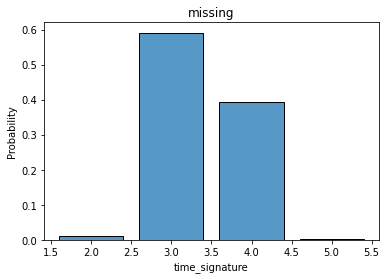

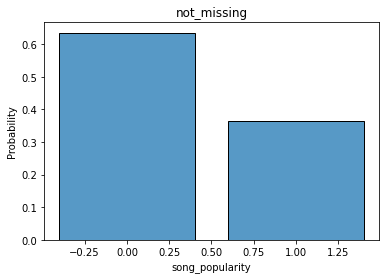

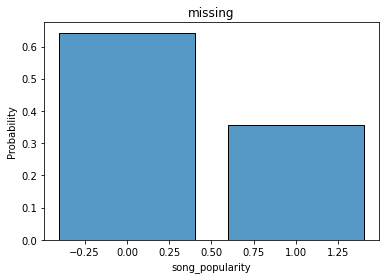

In [103]:
# check acousticness column
# slight difference found in audio valence
missing_analysis(df = train, selected_col= 'acousticness')

0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 
0 plotting key 
1 plotting audio_mode 


<ipython-input-101-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2 plotting time_signature 
3 plotting song_popularity 


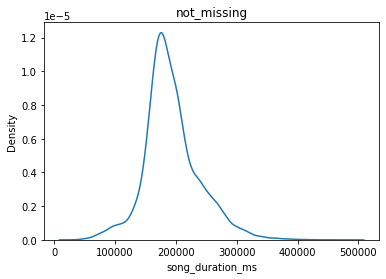

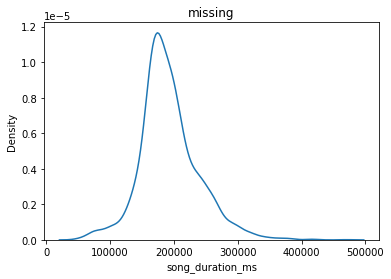

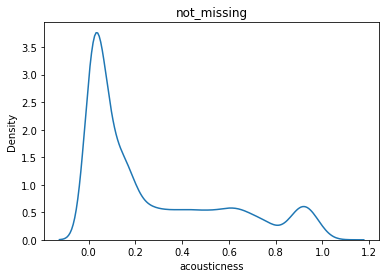

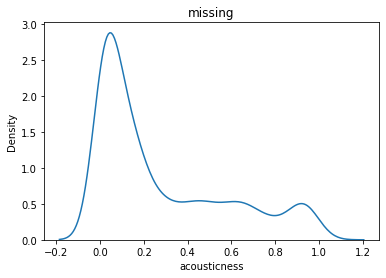

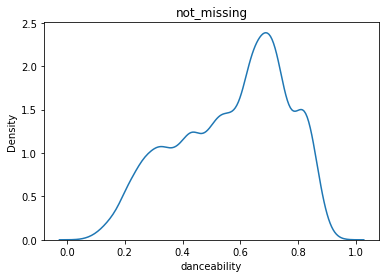

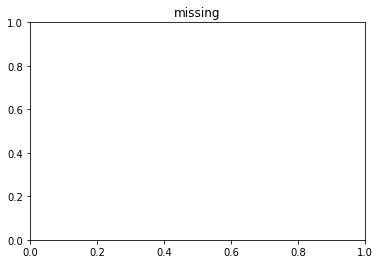

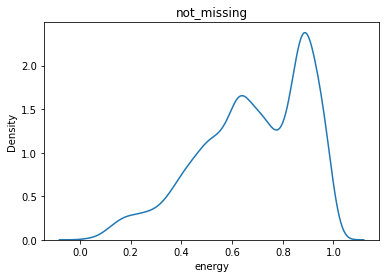

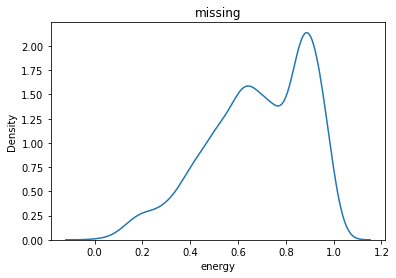

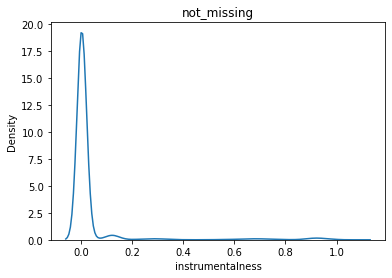

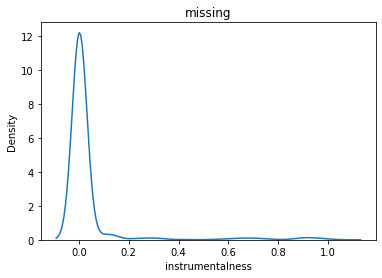

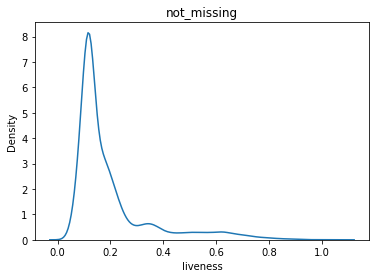

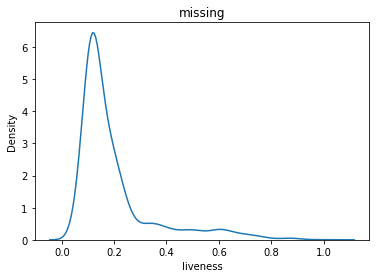

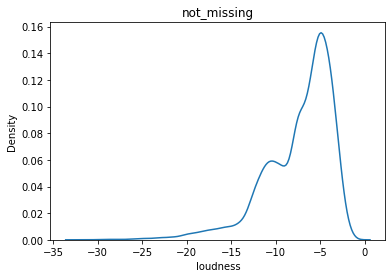

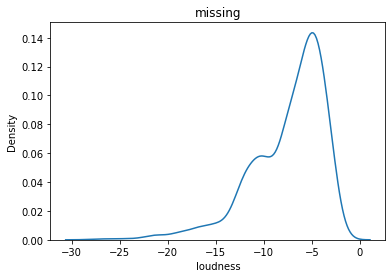

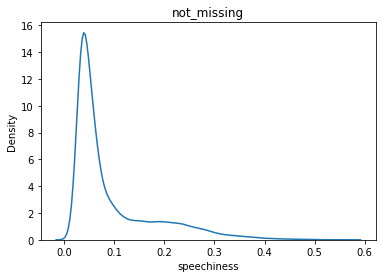

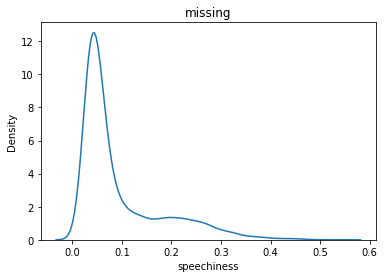

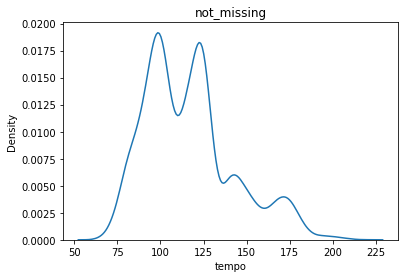

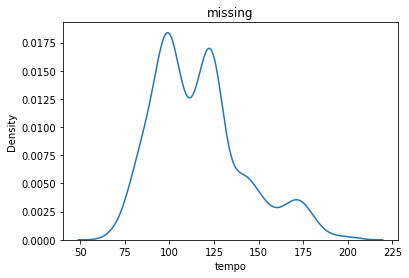

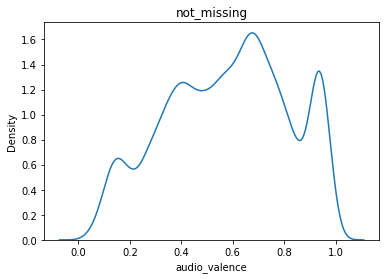

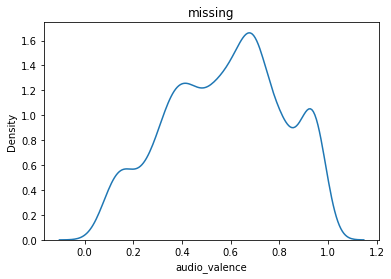

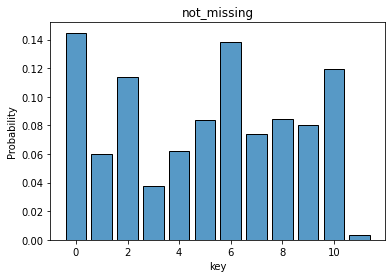

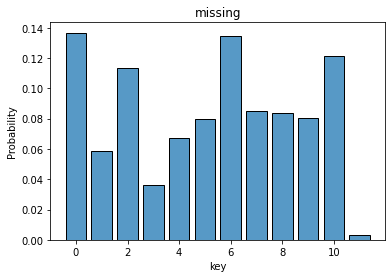

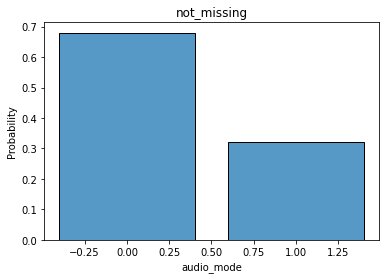

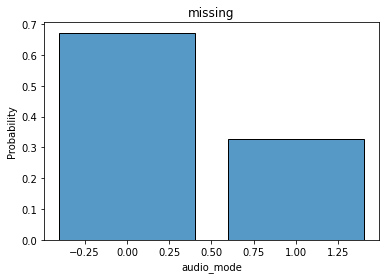

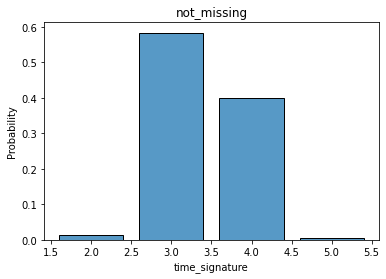

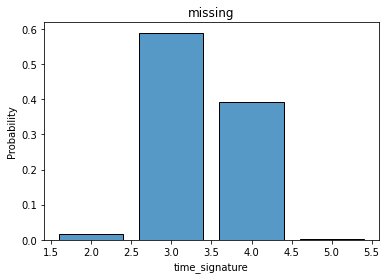

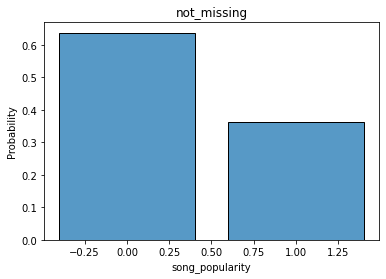

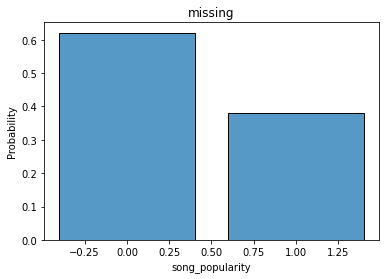

In [104]:
# check danceability column
# slight difference found in audio valence
missing_analysis(df = train, selected_col= 'danceability')




0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 
0 plotting key 
1 plotting audio_mode 


<ipython-input-101-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2 plotting time_signature 
3 plotting song_popularity 


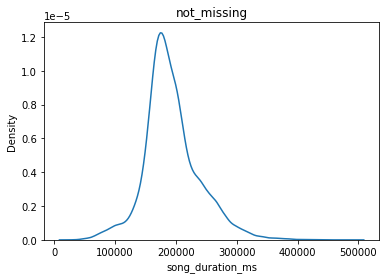

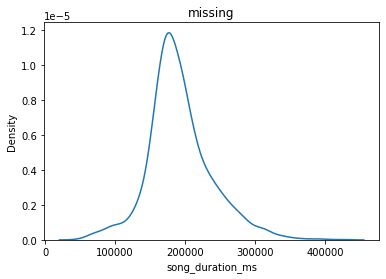

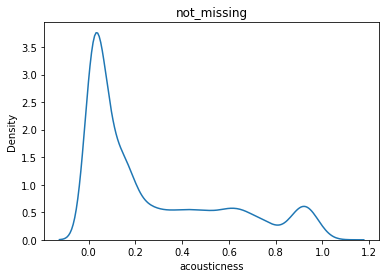

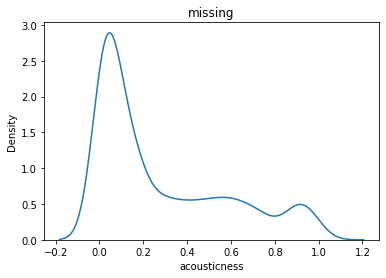

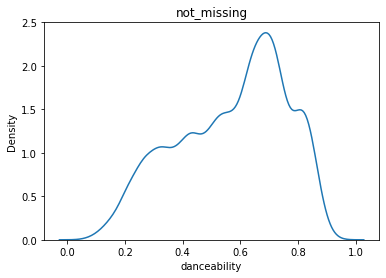

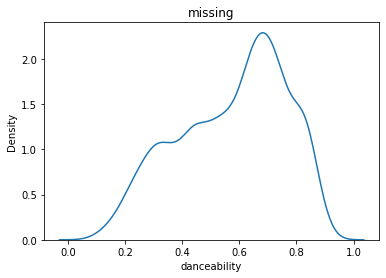

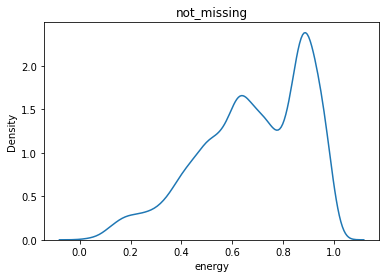

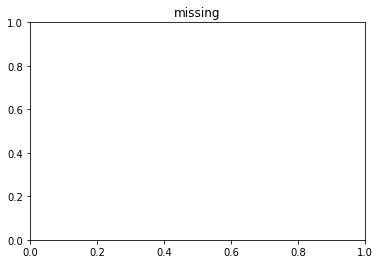

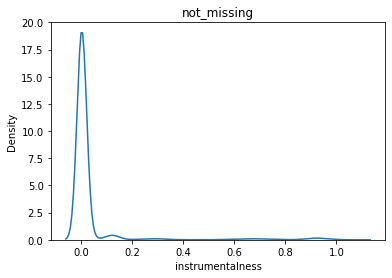

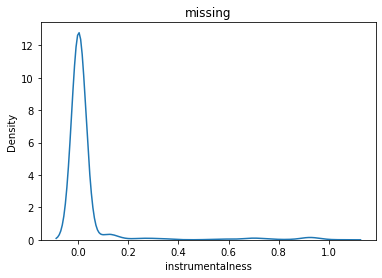

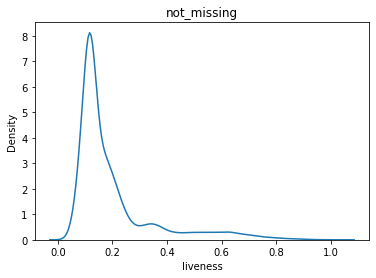

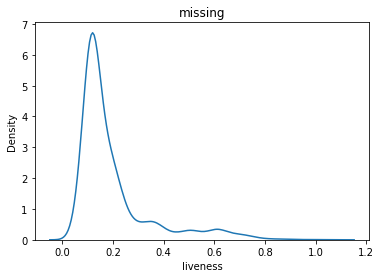

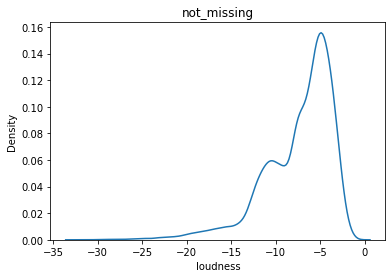

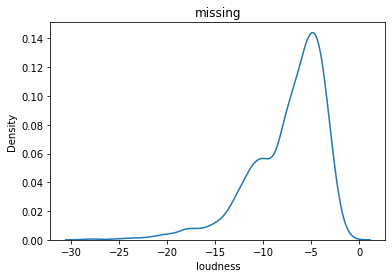

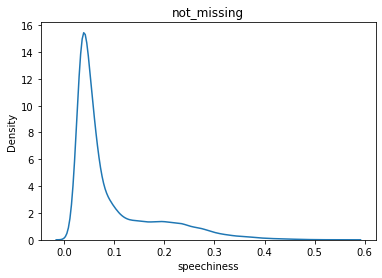

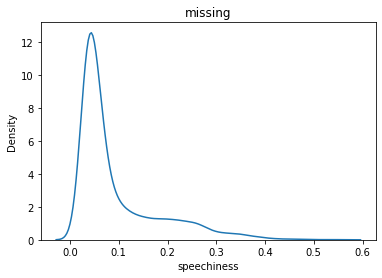

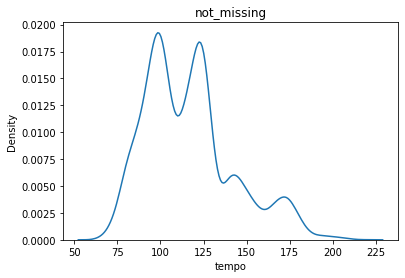

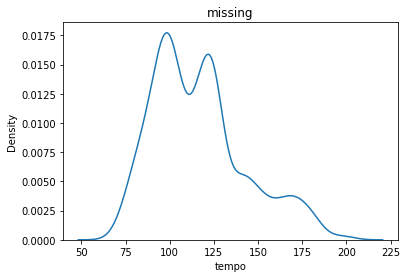

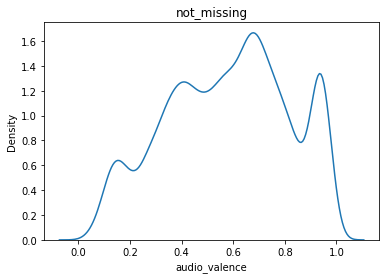

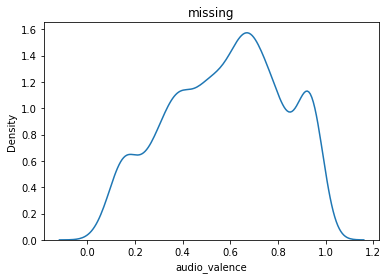

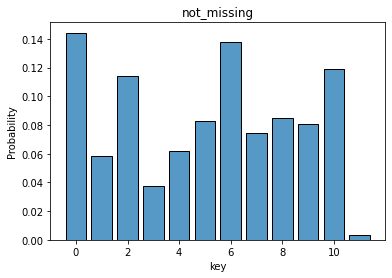

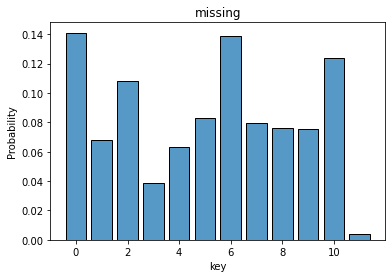

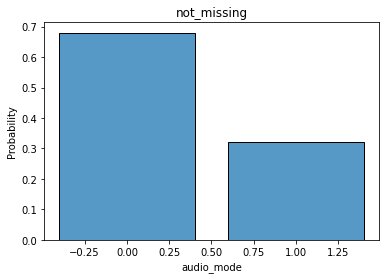

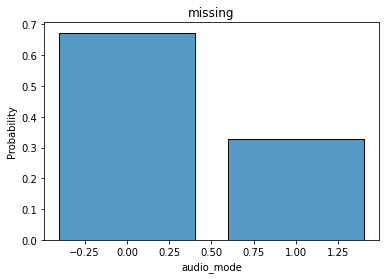

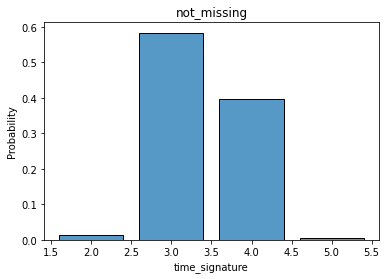

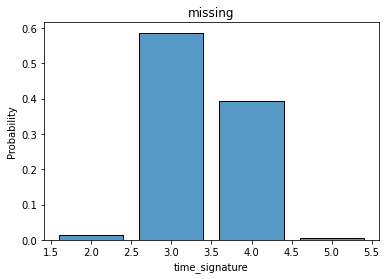

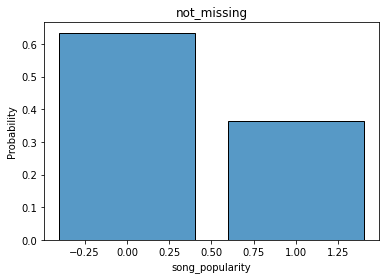

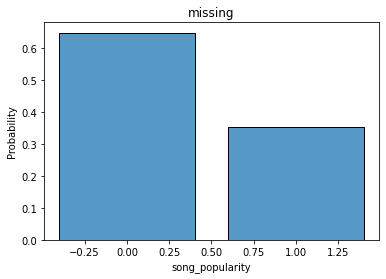

In [107]:
# check energy column
# slight difference found in audio valence & tempo
missing_analysis(df = train, selected_col= 'energy')

0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 
0 plotting key 
1 plotting audio_mode 


<ipython-input-101-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2 plotting time_signature 
3 plotting song_popularity 


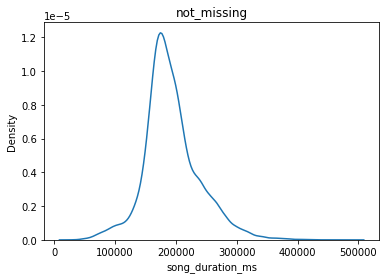

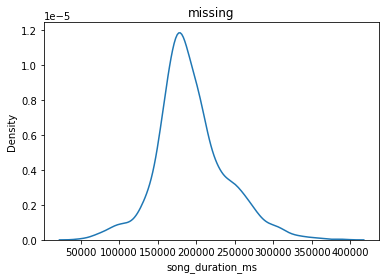

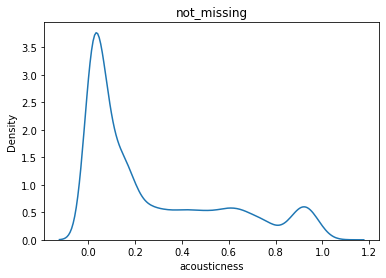

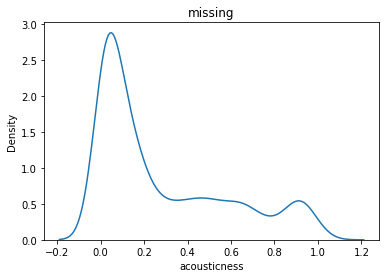

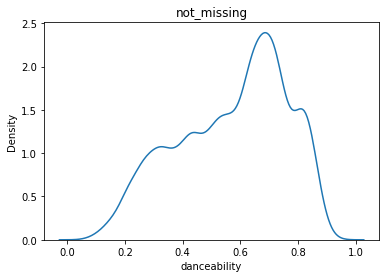

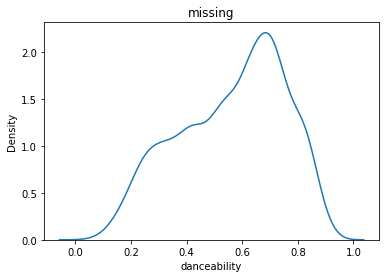

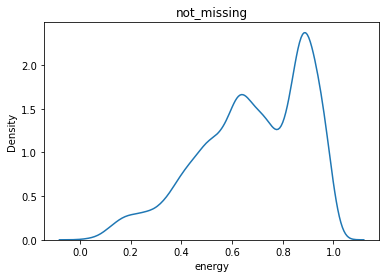

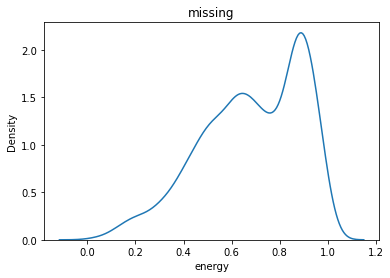

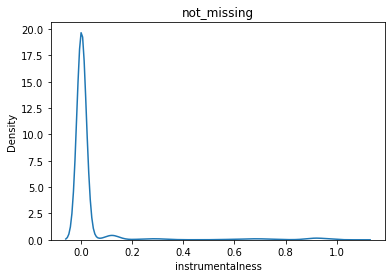

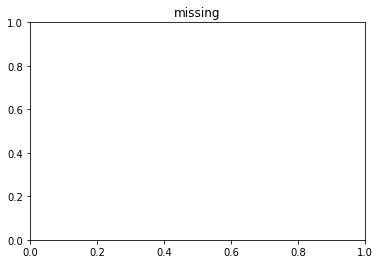

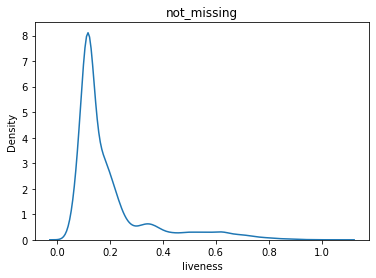

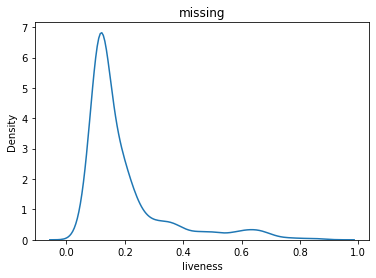

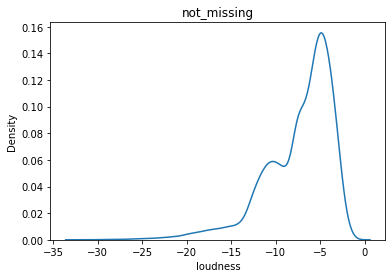

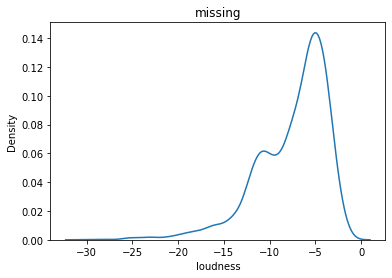

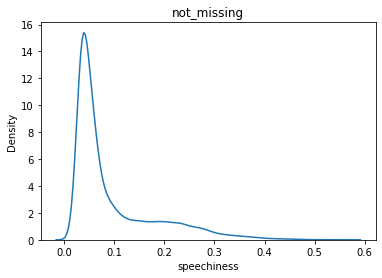

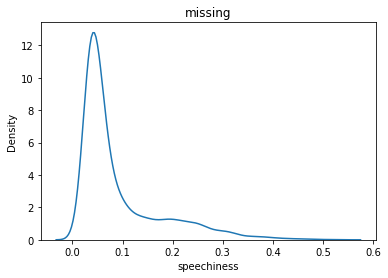

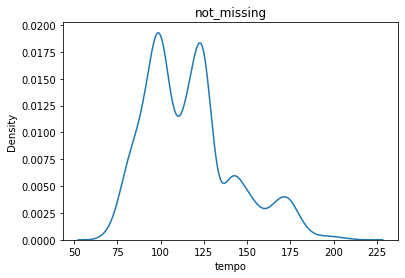

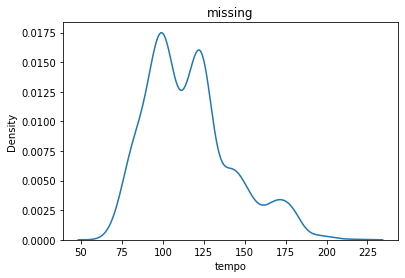

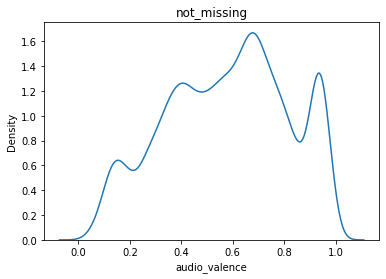

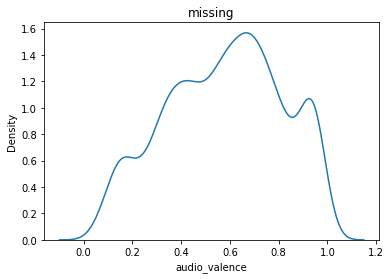

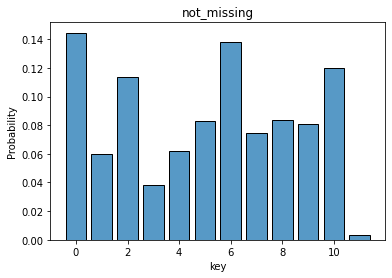

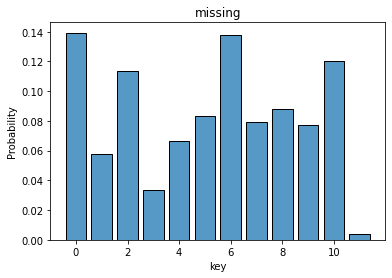

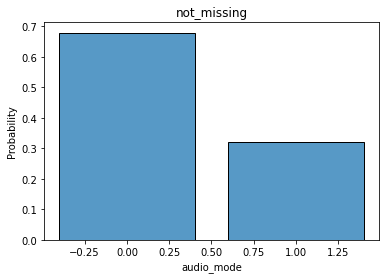

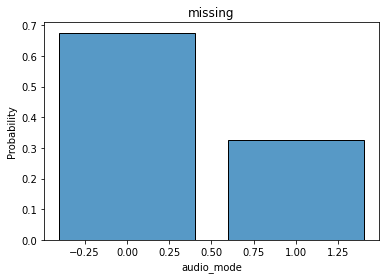

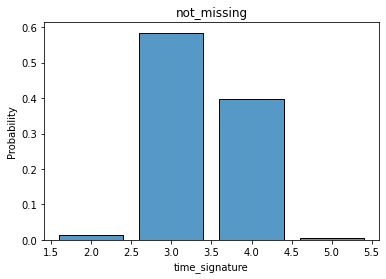

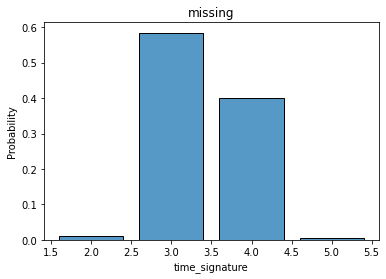

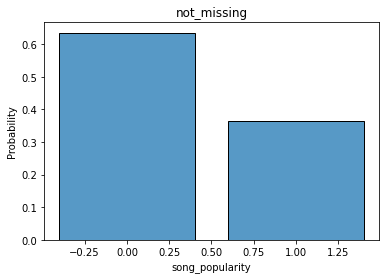

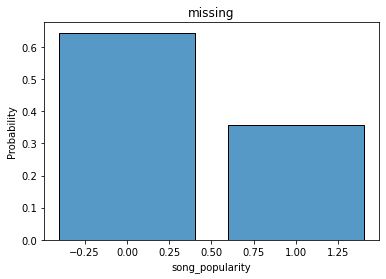

In [108]:

# check instrumentalness column
# no difference found 
missing_analysis(df = train, selected_col= 'instrumentalness')


0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 
0 plotting key 
1 plotting audio_mode 


<ipython-input-101-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2 plotting time_signature 
3 plotting song_popularity 


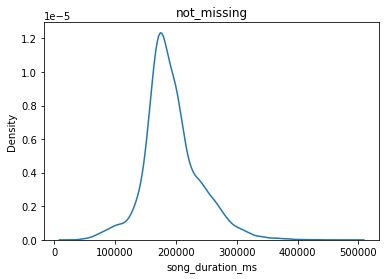

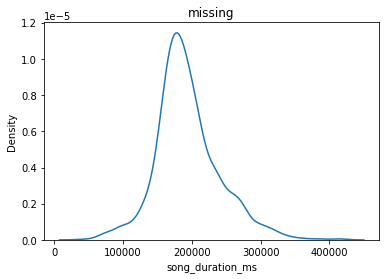

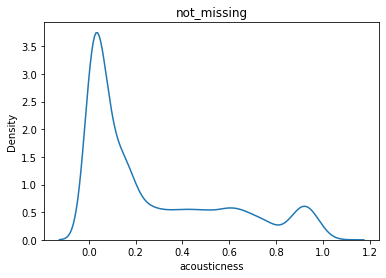

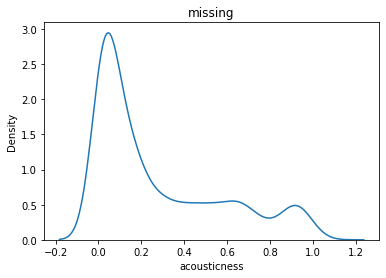

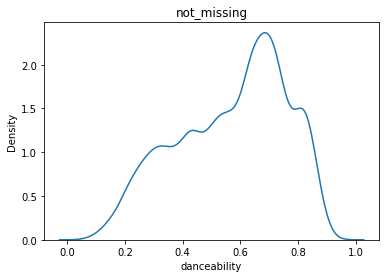

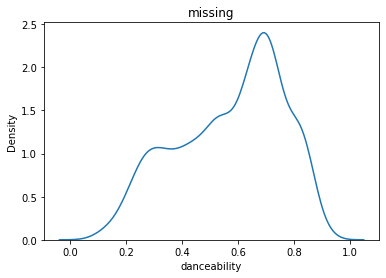

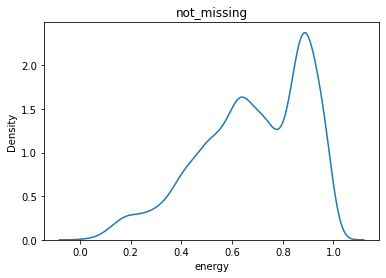

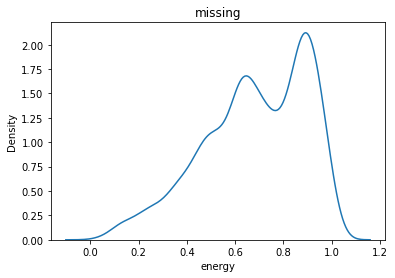

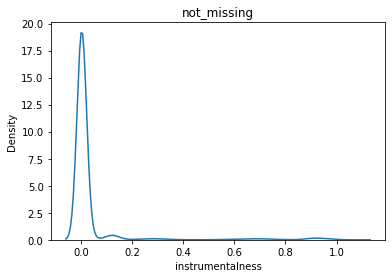

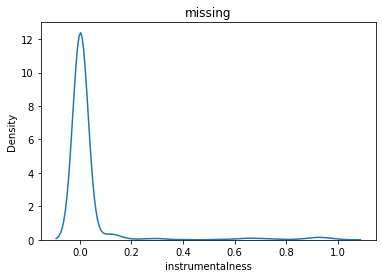

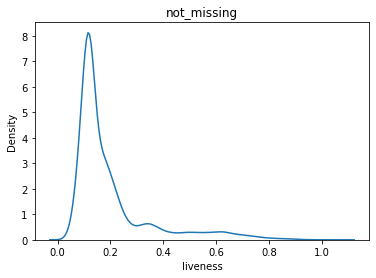

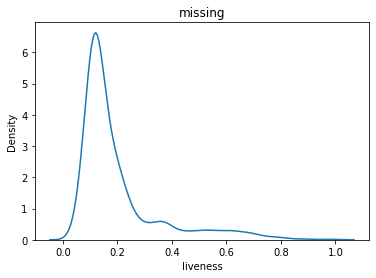

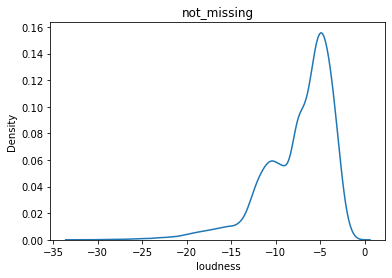

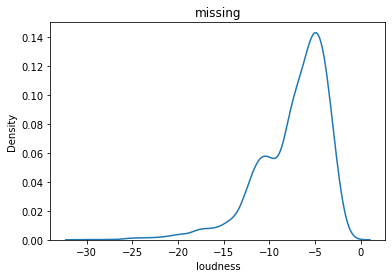

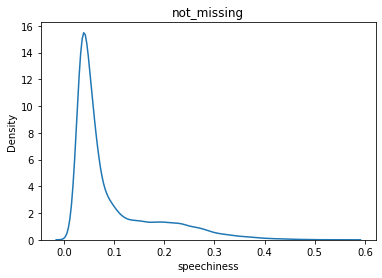

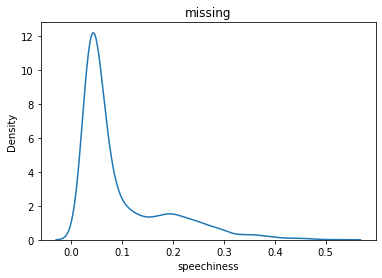

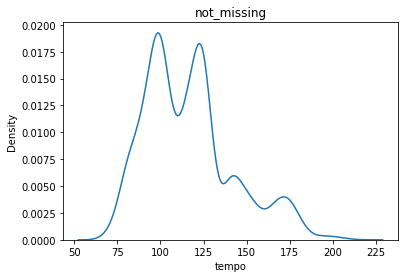

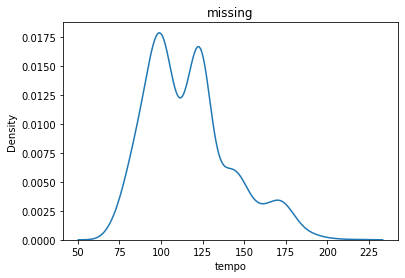

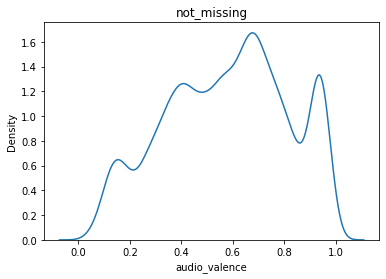

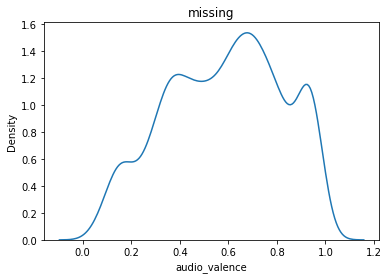

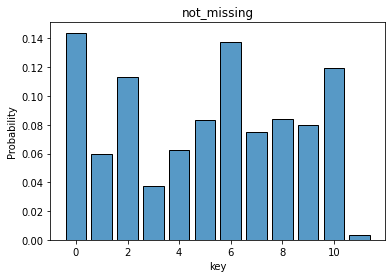

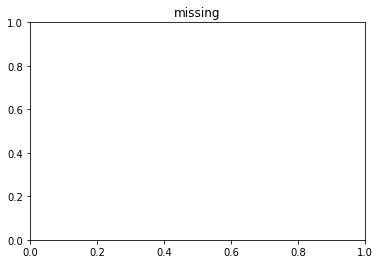

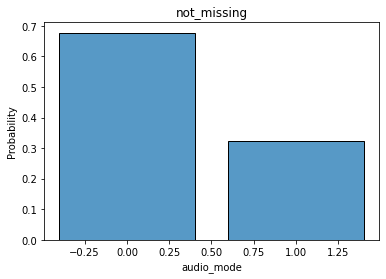

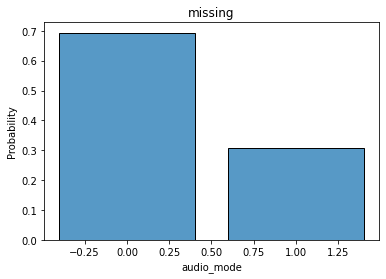

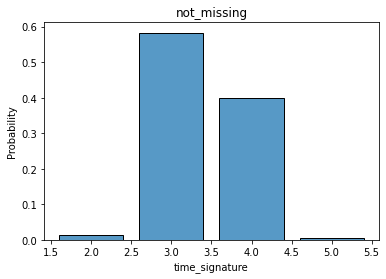

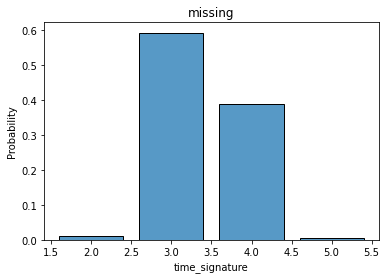

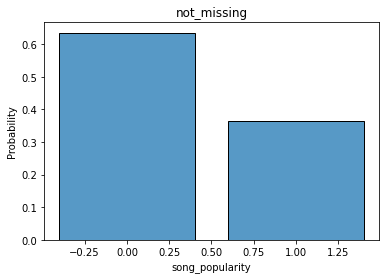

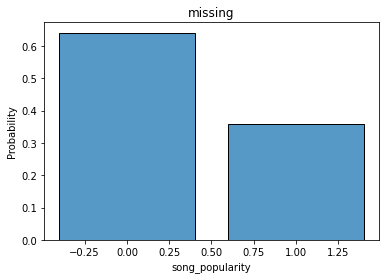

In [109]:

# check key column
# no difference found 
missing_analysis(df = train, selected_col= 'key')


0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 
0 plotting key 
1 plotting audio_mode 


<ipython-input-101-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2 plotting time_signature 
3 plotting song_popularity 


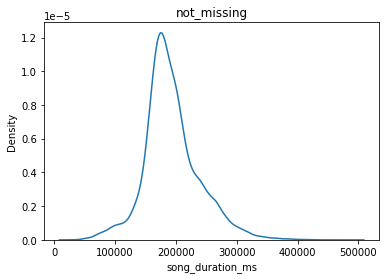

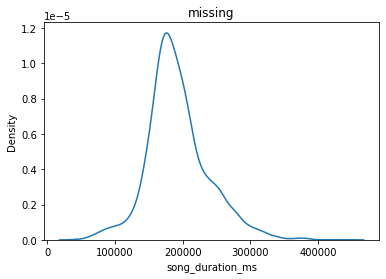

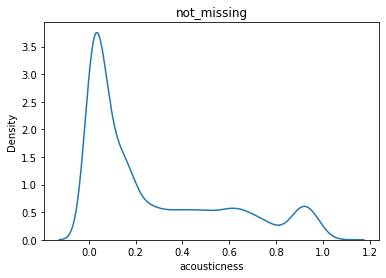

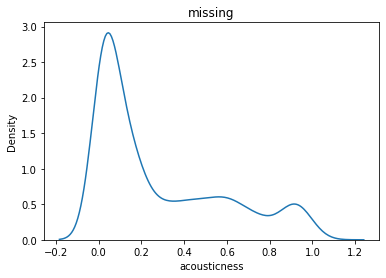

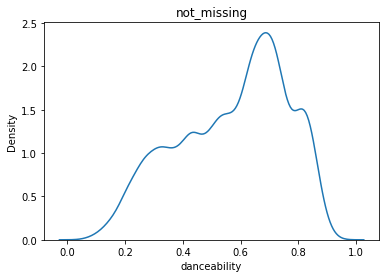

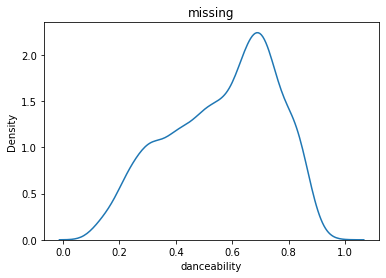

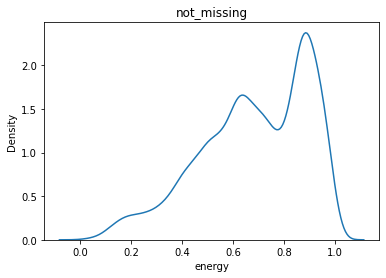

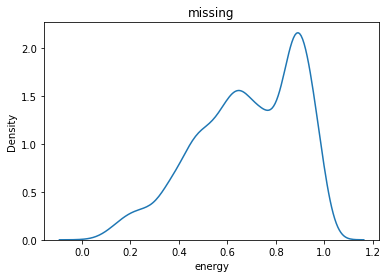

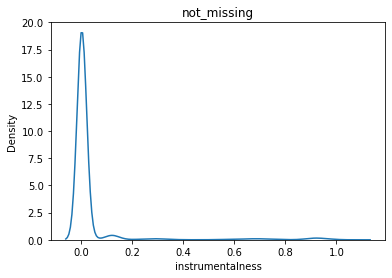

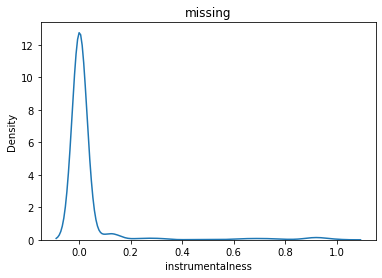

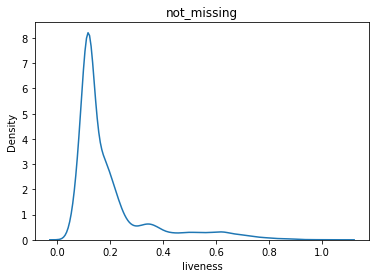

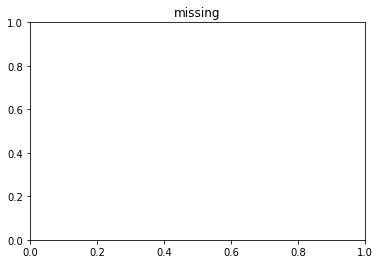

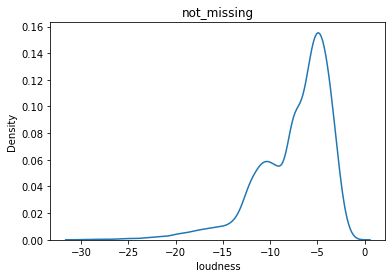

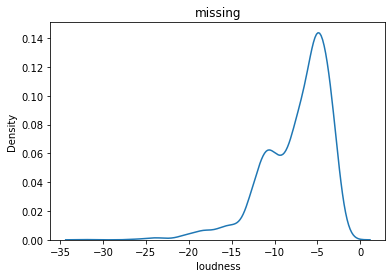

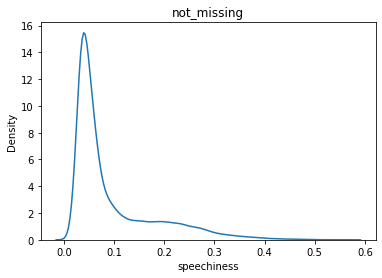

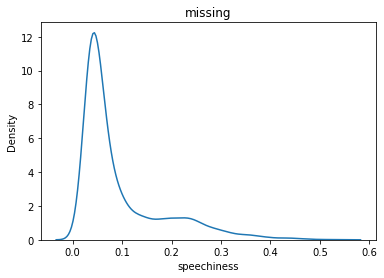

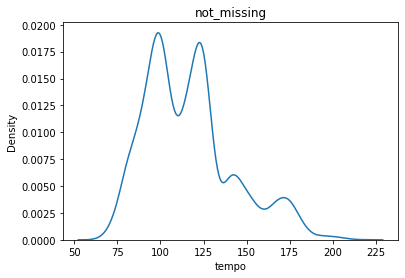

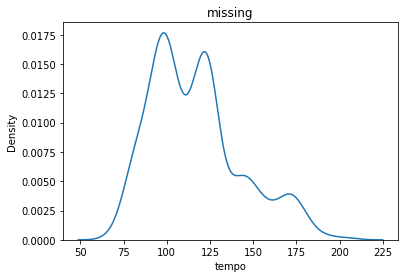

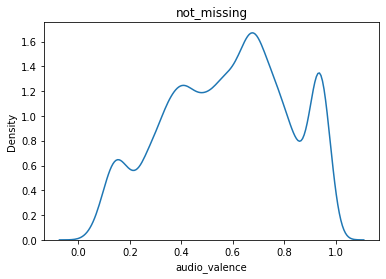

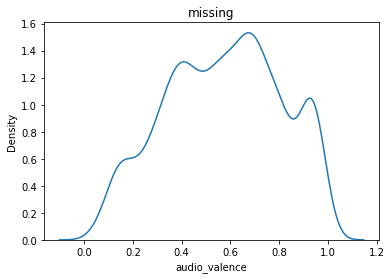

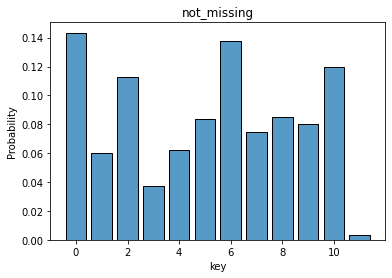

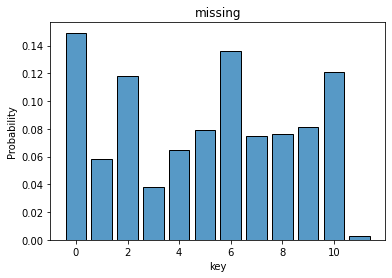

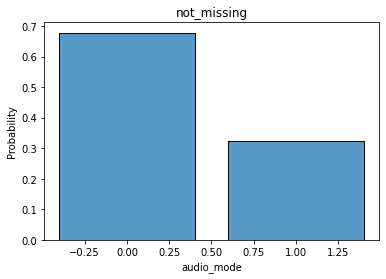

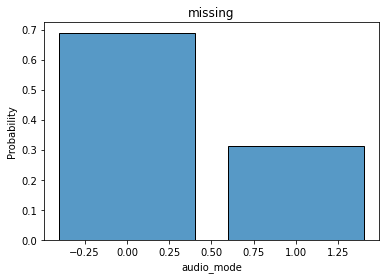

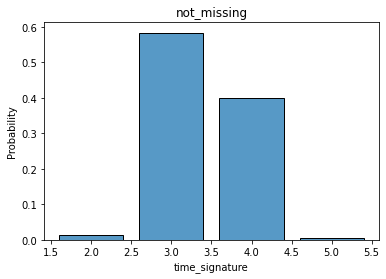

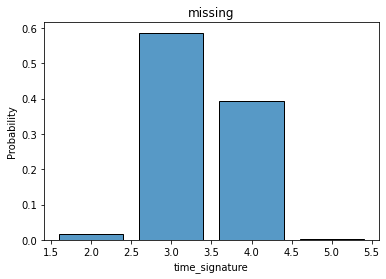

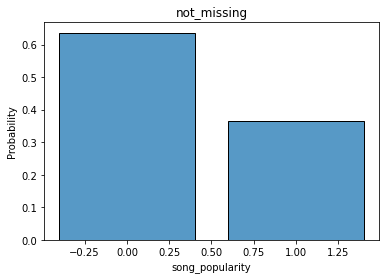

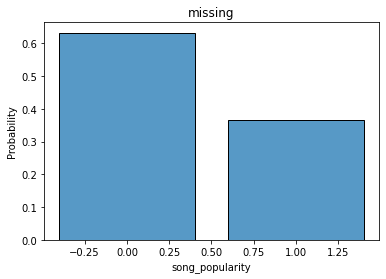

In [110]:

# check liveness column
# no difference found 
missing_analysis(df = train, selected_col= 'liveness')



0 plotting song_duration_ms 
1 plotting acousticness 
2 plotting danceability 
3 plotting energy 
4 plotting instrumentalness 
5 plotting liveness 
6 plotting loudness 
7 plotting speechiness 
8 plotting tempo 
9 plotting audio_valence 
0 plotting key 


<ipython-input-101-e009f2e28d59>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


1 plotting audio_mode 
2 plotting time_signature 
3 plotting song_popularity 


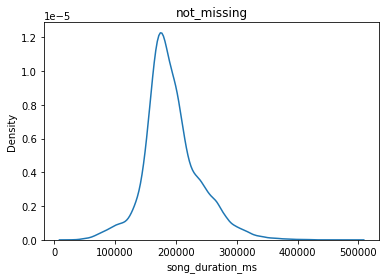

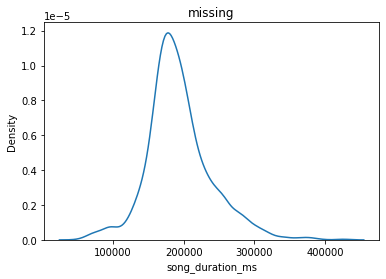

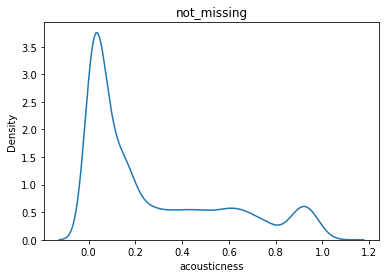

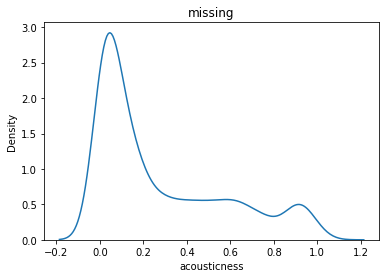

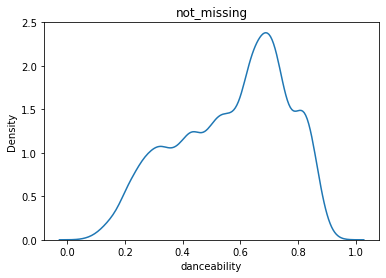

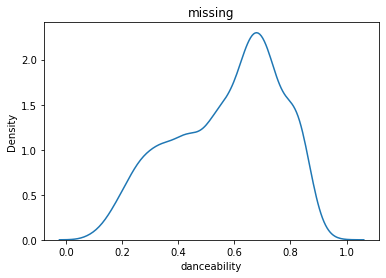

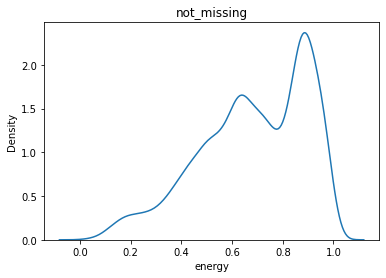

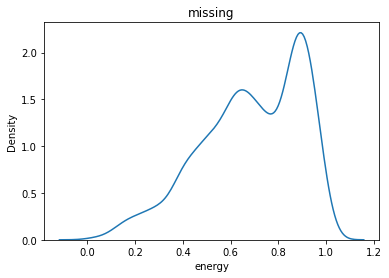

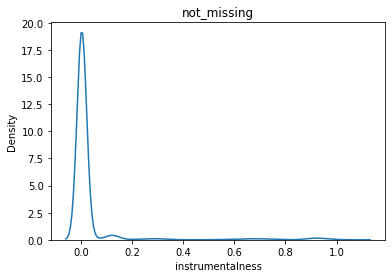

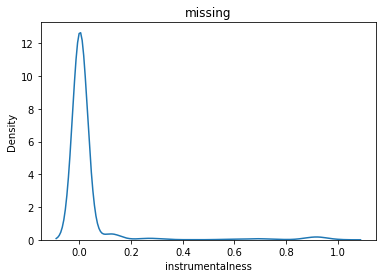

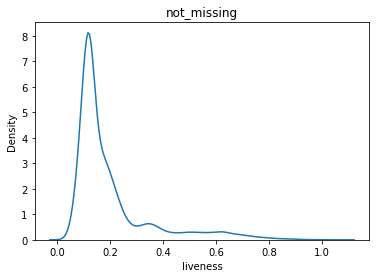

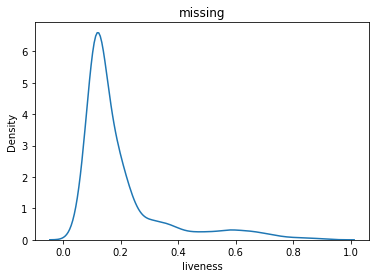

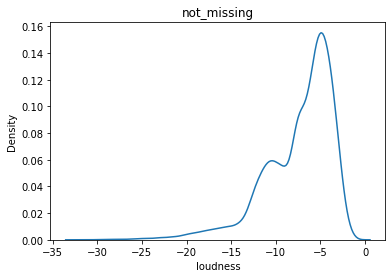

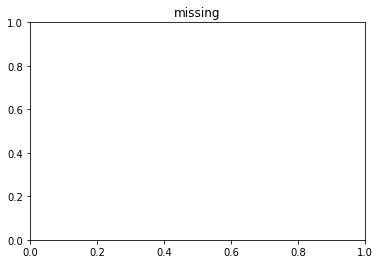

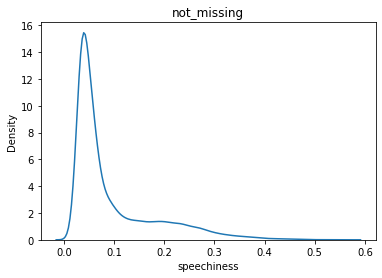

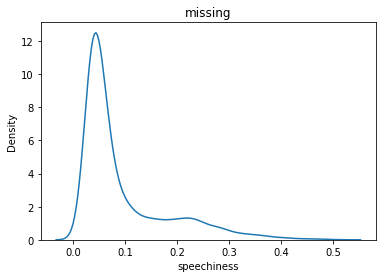

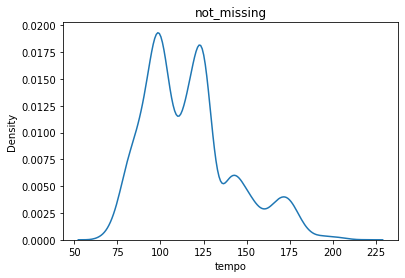

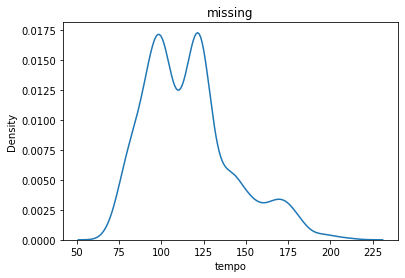

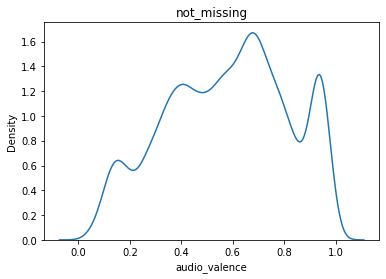

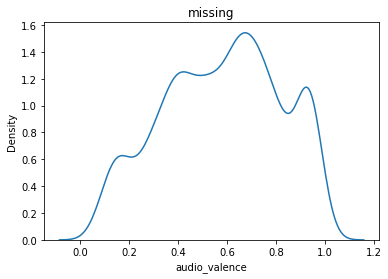

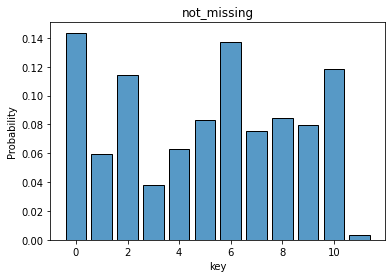

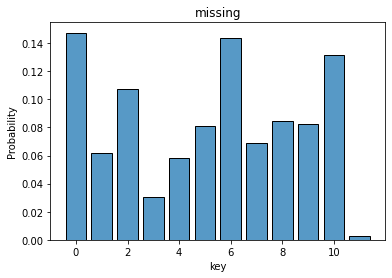

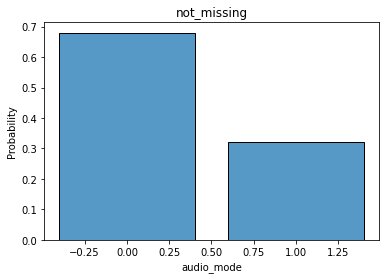

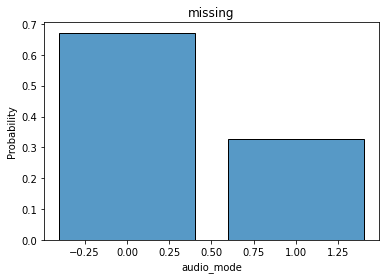

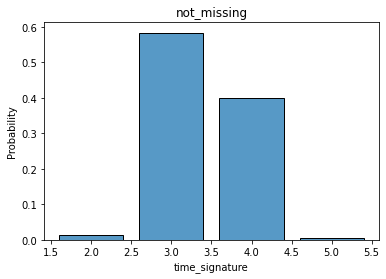

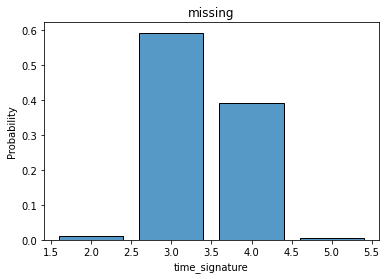

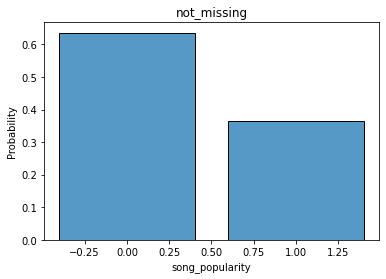

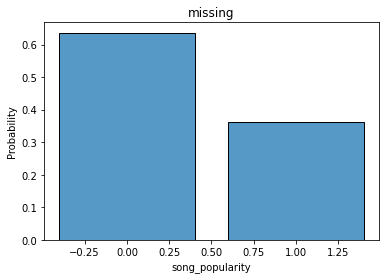

In [111]:

# check loudness column
# no difference found 
missing_analysis(df = train, selected_col= 'loudness')



# EDA


array([[<AxesSubplot:title={'center':'song_duration_ms'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'audio_valence'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

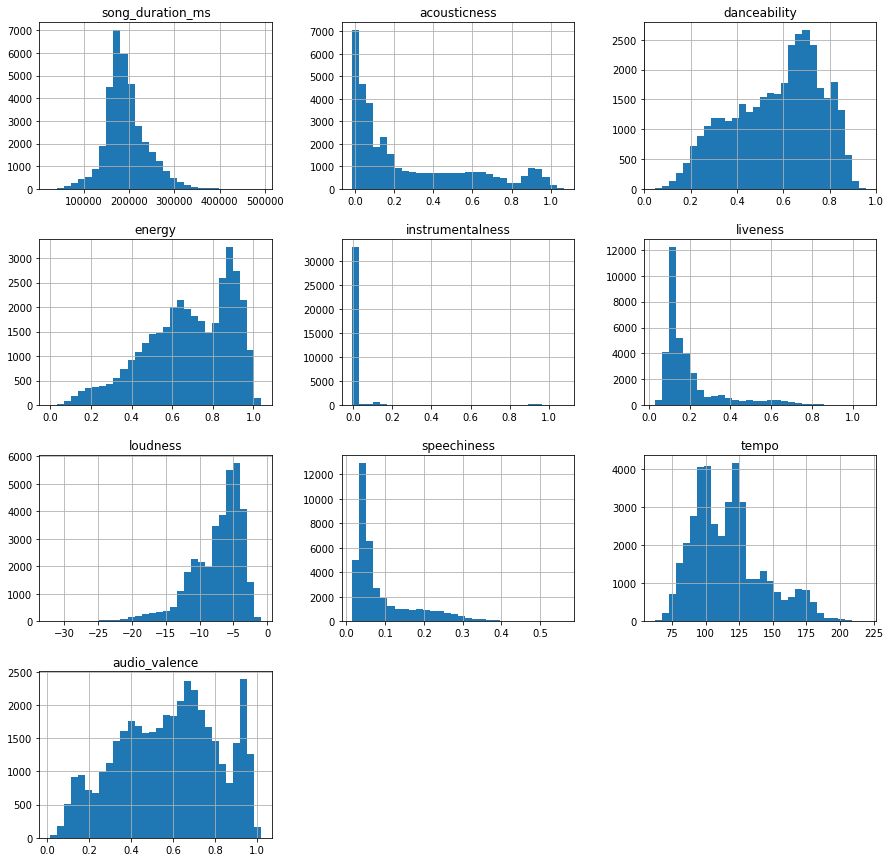

In [16]:
## Numerical variables
# all are not normally distributed except song duration

train[cont_vars].hist(bins = 30, figsize=(15,15))

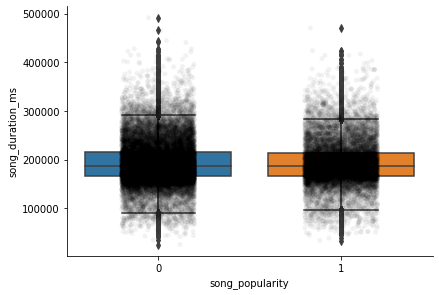

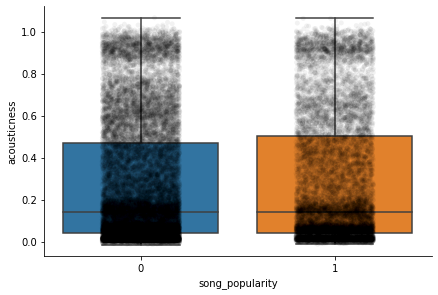

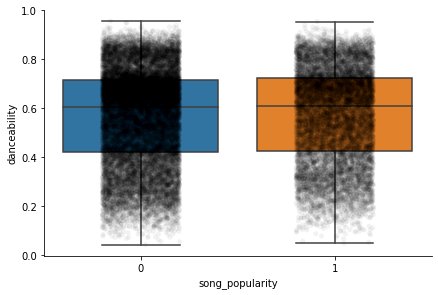

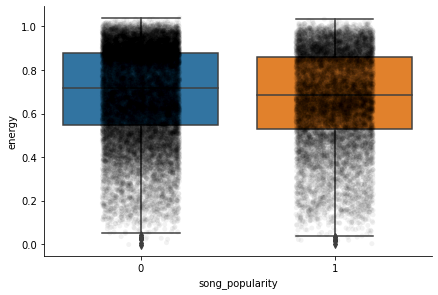

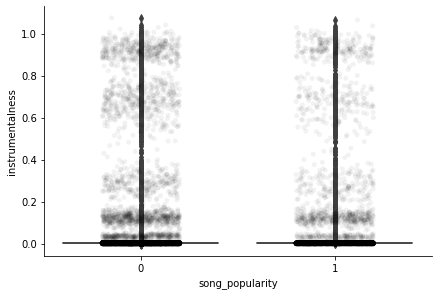

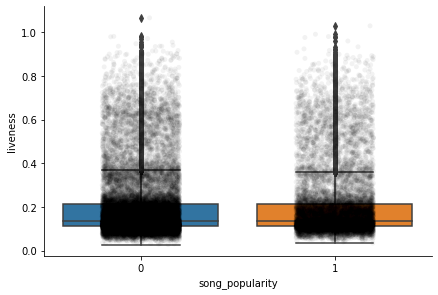

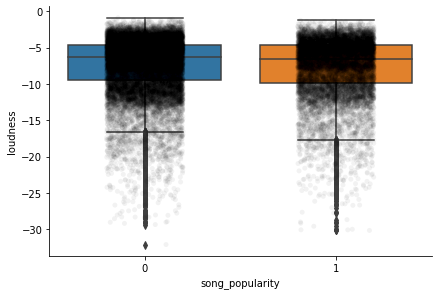

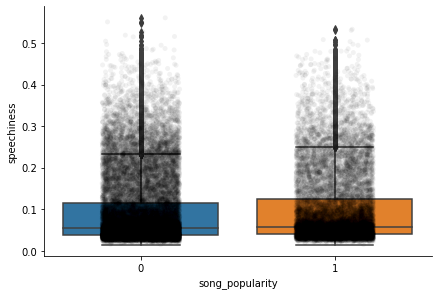

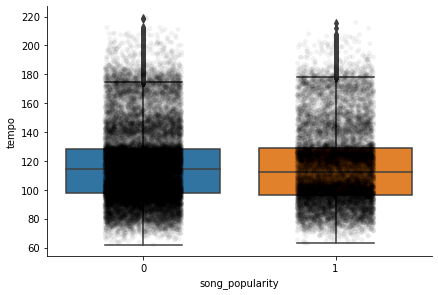

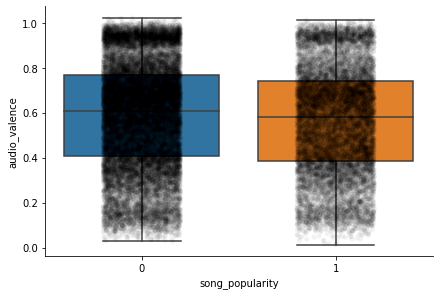

In [31]:
## relationship between numerical variables with target variables 
## before transformation
for var in cont_vars:
    sns.catplot(x = "song_popularity", y = var, data = train, kind = 'box', height=4, aspect=1.5)
    sns.stripplot(x =  "song_popularity", y = var, data = train, jitter = 0.2, alpha = 0.05, color = 'k')
    plt.show()

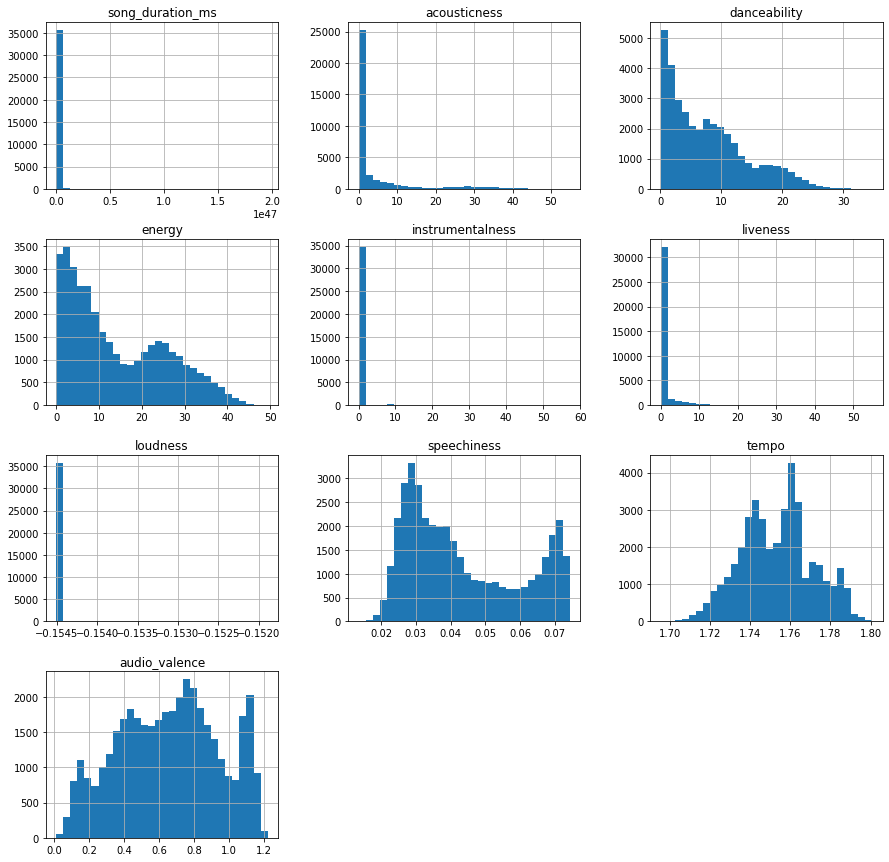

In [33]:
# Yeo-johnson transformation
# tempo looks better
tmp = train.copy()

for var in cont_vars:
    tmp[var], param = stats.yeojohnson(train[var])

tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

C:\Users\benlc\anaconda3\envs\data-science\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


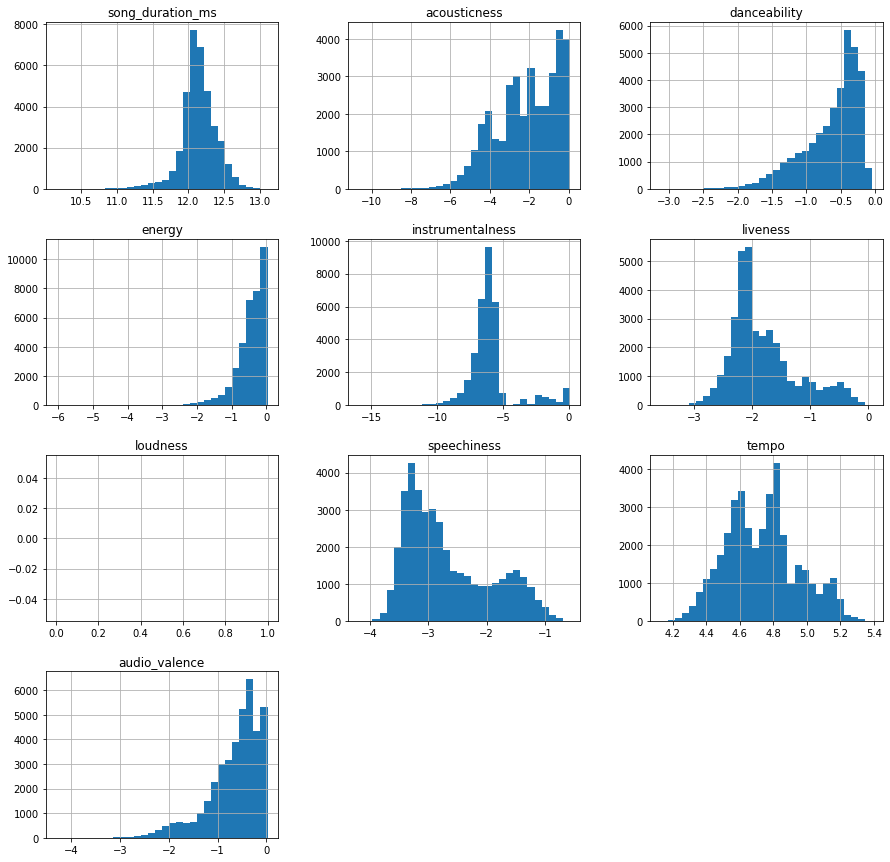

In [35]:
# log transformation
# liveness
tmp = train.copy()

for var in cont_vars:
    tmp[var]= np.log(train[var])

tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

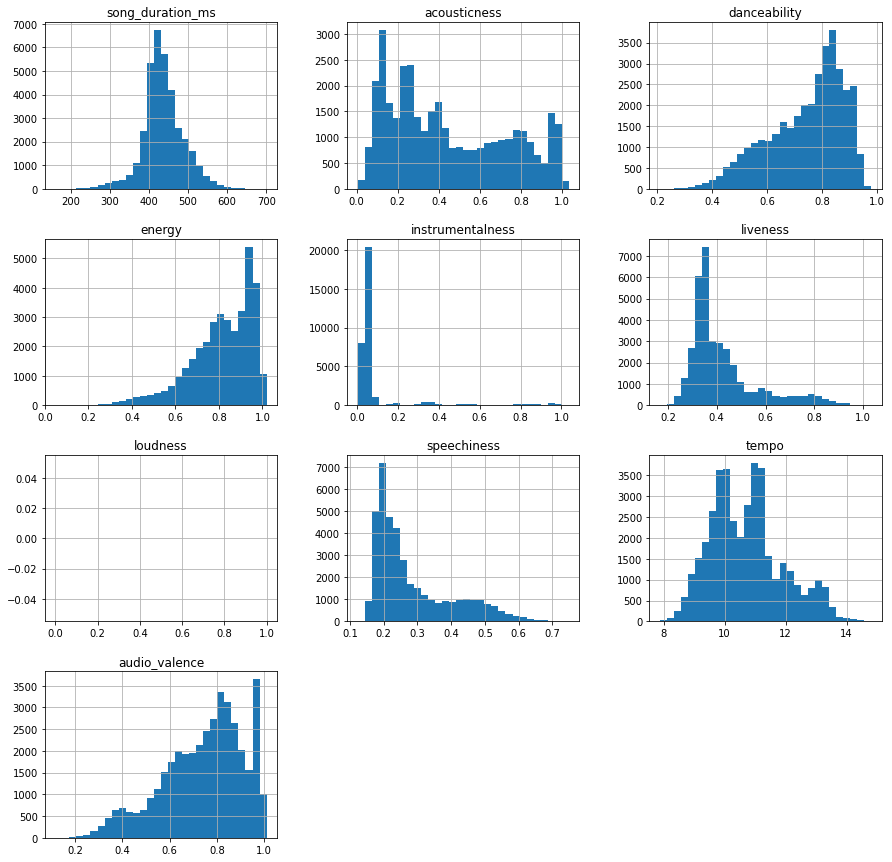

In [36]:
# Square root transformation
# better for song duration
tmp = train.copy()

for var in cont_vars:
    tmp[var]= train[var]**(1/2)

tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()


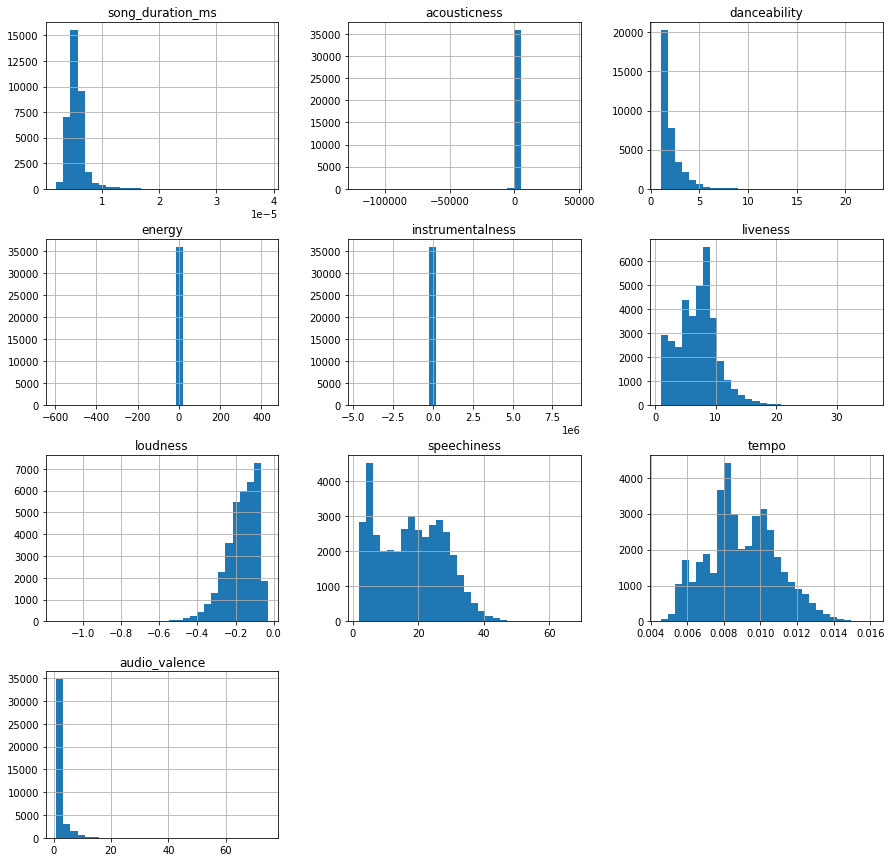

In [37]:
# reciprocal transformation
# none
tmp = train.copy()

for var in cont_vars:
    tmp[var]= 1/train[var]

tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()


song_duration_ms
danceability
liveness
speechiness
tempo
audio_valence


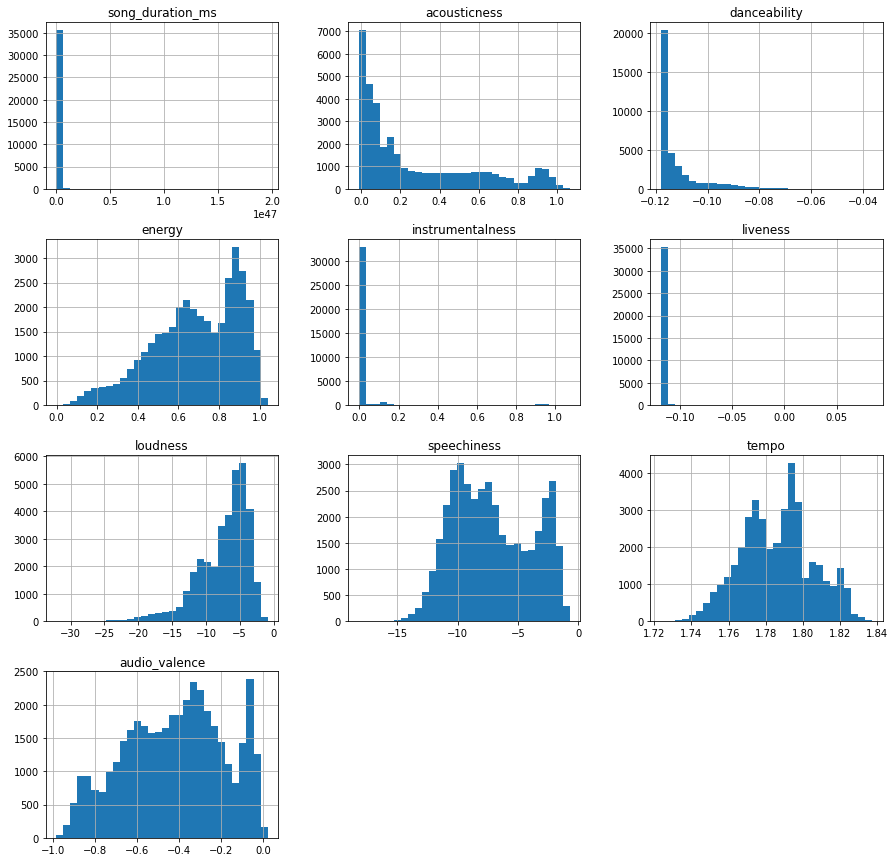

In [49]:
# boxcox transformation
# none
tmp = train.copy()
cont_vars_2 = ['song_duration_ms',
 'danceability',
 'liveness',
 'speechiness',
 'tempo',
 'audio_valence']

for var in cont_vars_2:
    tmp[var], lam= stats.boxcox(train[var])

tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

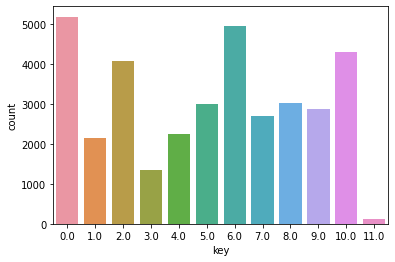

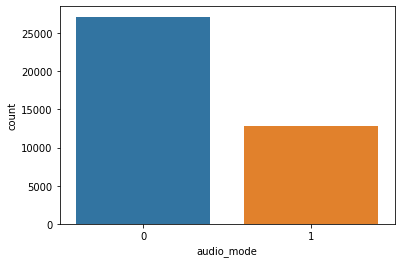

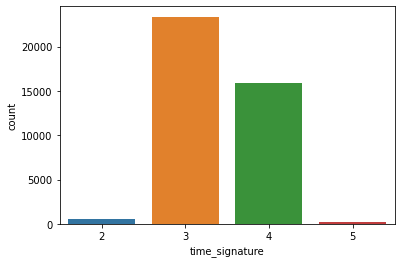

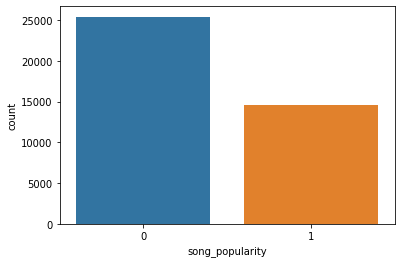

In [52]:
## categorical variables
# rare levels for key and time signature
# slightly imbalance for song popularity
for var in cat_vars:
    sns.countplot(x = var, data = train)
    plt.show()

## Sklearn pipeline

In [113]:
from sklearn.pipeline import Pipeline
from feature_engine import imputation

In [117]:
cols_to_use

['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness']

In [132]:
cols_to_use = [var for var in cont_vars if var in vars_with_na]
cols_to_use

imputer = imputation.RandomSampleImputer()
imputer = imputation.MeanMedianImputer(imputation_method="median")

pipe = Pipeline([
    ("add_missing_ind_col", imputation.AddMissingIndicator(missing_only=True)),
    ("median_imputer", imputation.MeanMedianImputer(imputation_method="median",
                                                    variables=['song_duration_ms','acousticness','danceability','energy'])),
    ("random_imputer", imputation.RandomSampleImputer( random_state=123,
                                                    variables=['instrumentalness','liveness','loudness'])),
    ("add_missing_ind_row", imputation.CategoricalImputer(
                                                    variables=['key']))
])

imputed_train = pipe.fit_transform(train)

C:\Users\benlc\anaconda3\envs\data-science\lib\site-packages\pandas\core\arrays\categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [125]:
pipe.named_steps

{'median_imputer': MeanMedianImputer(variables=['song_duration_ms', 'acousticness', 'danceability',
                              'energy']),
 'random_imputer': RandomSampleImputer(variables=['instrumentalness', 'liveness', 'loudness'])}

In [133]:
imputed_train

id  song_duration_ms  acousticness  danceability    energy  \
0          0          212990.0      0.642286      0.856520  0.707073   
1          1          186660.0      0.054866      0.733289  0.835545   
2          2          193213.0      0.140532      0.188387  0.783524   
3          3          249893.0      0.488660      0.585234  0.552685   
4          4          165969.0      0.493017      0.608234  0.740982   
...      ...               ...           ...           ...       ...   
39995  39995          237799.0      0.140532      0.748942  0.511234   
39996  39996          191119.0      0.067488      0.672830  0.889685   
39997  39997          160879.0      0.877431      0.409065  0.292671   
39998  39998          193918.0      0.140532      0.365738  0.704453   
39999  39999          196475.0      0.007116      0.354585  0.994883   

       instrumentalness   key  liveness   loudness audio_mode  ...  \
0              0.002001  10.0  0.120344  -5.619088          0  ...   
1              0.000996   8.0  0.436428  -5.236965          1  ...   
2             -0.002694   5.0  0.170499  -4.951759          0  ...   
3              0.000608   0.0  0.094805  -7.893694          0  ...   
4              0.002033  10.0  0.094891  -2.684095          0  ...   
...                 ...   ...       ...        ...        ...  ...   
39995          0.002913   0.0  0.173803  -8.853673          0  ...   
39996          0.001225   5.0  0.122924  -7.798993          0  ...   
39997          0.000627  10.0  0.110664 -15.378585          0  ...   
39998          0.000339   1.0  0.356308  -4.661977          1  ...   
39999          0.002191   1.0  0.200900  -4.875249          0  ...   

       audio_valence  song_popularity song_duration_ms_na  acousticness_na  \
0           0.734642                0                   0                0   
1           0.711531                1                   1                0   
2           0.425536                0                   0                1   
3           0.453597                0                   0                0   
4           0.741311                0                   0                0   
...              ...              ...                 ...              ...   
39995       0.178159                0                   0                1   
39996       0.790626                0                   0                0   
39997       0.177947                1                   0                0   
39998       0.772978                0                   0                1   
39999       0.588549                0                   0                0   

      danceability_na  energy_na  instrumentalness_na  key_na  liveness_na  \
0                   0          0                    0       0            1   
1                   0          0                    0       0            0   
2                   0          0                    0       0            0   
3                   0          0                    0       0            0   
4                   1          0                    0       0            0   
...               ...        ...                  ...     ...          ...   
39995               0          0                    0       0            0   
39996               0          0                    0       0            0   
39997               0          0                    1       0            0   
39998               0          1                    0       0            0   
39999               0          0                    0       0            0   

       loudness_na  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
39995            0  
39996            0  
39997            0  
39998            0  
39999            0  

[40000 rows x 23 columns]